# **18高阶RAG：Agentic RAG**

前面教程中，我们学习到了如何构建 RAG 系统，以及对 RAG 系统进行效果提升、速度优化、功能扩展等等方面。本教程我们将在此基础上进一步介绍最近很火的Agentic RAG，它是RAG的变种，但更加智能，让我们开始吧！

> 如果把 **RAG ​**比作带着**书本**去考试的考生，那么 Agentic RAG 就是同时带着**老师和书**一起去考试的考生！

[18讲相关代码GitHub链接](https://github.com/LazyAGI/Tutorial/tree/main/rag/codes/chapter18)

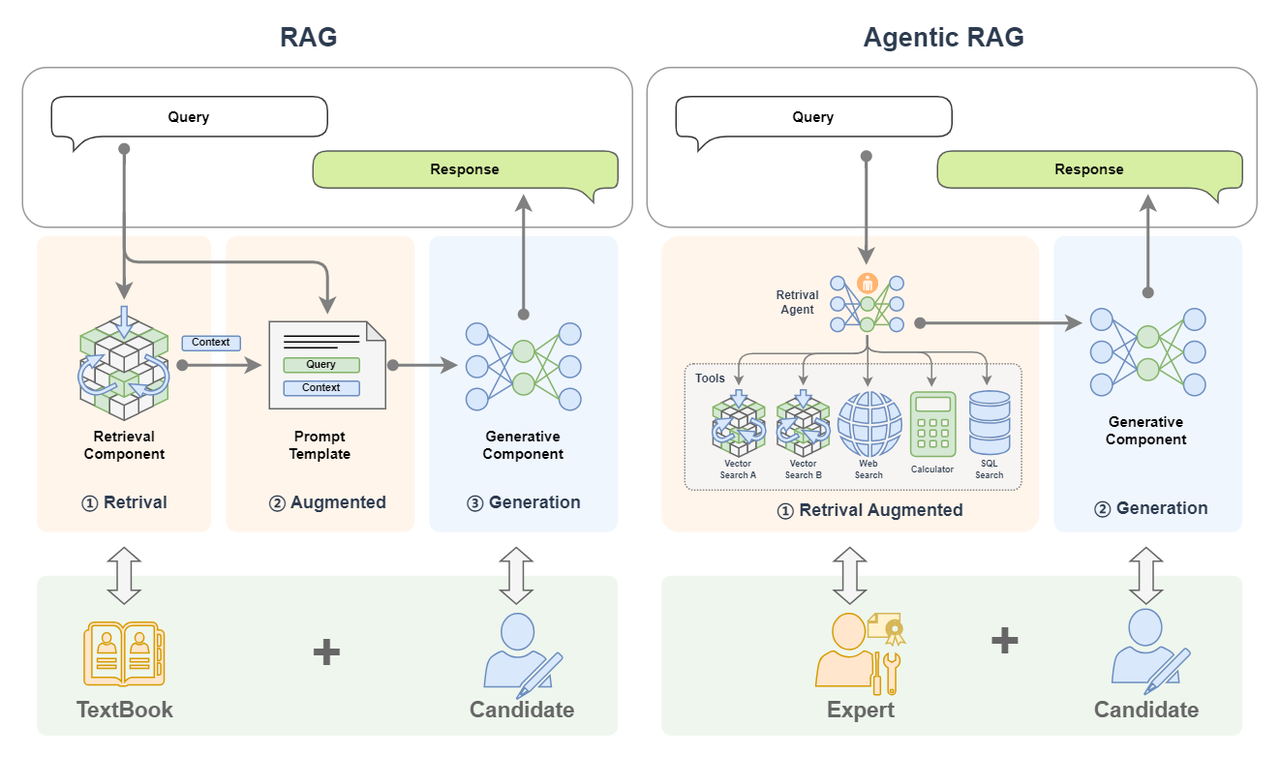

Agentic RAG 就是整合了 AI Agent 的 RAG。本文将先从 RAG、AI Agent 等概念为基础引出 Agentic RAG；然后详细介绍 Agentic RAG 的基本原理和组成；紧接着介绍为什么要用 Agentic RAG，并与传统的 RAG 进行对比；最后介绍如何搭建一个 Agentic RAG。

# 基本概念

什么是 Agentic RAG ? 让我们将这个复杂的概念先拆解为 RAG 和 AI Agent（Agentic 就是引入了 AI Agent）来逐个进行介绍。

## 1. 回顾 RAG 系统

首先让我们先回顾一下 RAG 的基本概念。

### 基本概念

检索增强生成（Retrieval-Augmented Generation，简称RAG）技术是一种利用外挂知识源为大语言模型补充上下文来强化输入从而提高大语言模型生成内容质量，并减少幻觉（hallucinations，幻觉即 LLM 自信地编造信息随意发挥生成的不真实的内容）的技术。打个比方来说，RAG就是一个带着书本去考试的考生。考题就是输入，书本就是外挂的知识库，考生就是大模型，考生作答的内容就是大模型生成的内容。一般来说如果一门闭卷考能够带着教科书去考试，那答卷的分数都会很高，这也正是RAG能提高大模型生成内容质量的一个形象解释。

### 基本组件

RAG 主要包括了两个组件：

* 检索组件（Retrieval Component）：检索组件用于根据输入去匹配知识库中的信息，打个比方就是带着考题去教科书中搜索答案。
* 生成组件（Generative Component）：生成组件用于把输入和检索到的信息送给大模型来生成高质量的回复，打个比方就是：考生结合题目和从教科书中找到的内容来回答试题。

### 工作流程

RAG （Retrieval-Augmented Generation）这个名字已经将这个技术的工作流程给揭示了出来，让我们结合图示并将名字进行拆解来看：

* 首先我们输入一个 query：
  * ① Retrieval：检索，query 首先被用于在一个知识库中进行检索（这里简化了 RAG 中embedding、向量化等细节，详细可见往期教程[基础2：初识RAG](https://github.com/LazyAGI/Tutorial/tree/main/rag/notebook/chapter2/2.ipynb)，知识库中的文档以及 query 都会被向量化以便进行相似度计算，下文图中 Vector Search 对应的就是对知识库的搜索）；
  * ② Augmented：增强，将检索到的内容（context）与我们输入的 query 进行拼接，以达到增强 query 的效果；
  * ③ Generation：生成，将上一步增强后的 query 送入到 LLM 大模型来生成回复的内容。
* 将生成的内容返回。

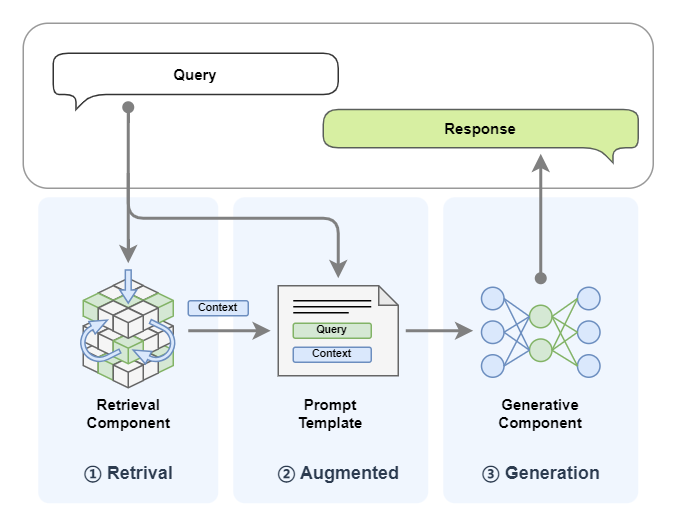

## 2. AI Agent 简介

### 基本概念

首先 Agent 是什么？中文中常见翻译为：代理人。我们要做一件事，一般有两种方式，自己一步一步来达成；另外就是找个人，这个人就叫做代理人，我们全权授权给代理人而不用关心他怎么做，只管他能帮我们达到目的。前者我们需要操心每个细节，而后者我们可以坐享其成。所以 Agent 的一个特点就是：不需要我们去关心达成某个任务的细节，而只需要放心把任务交给他，让他去帮我们达成。

回到 AI 智能体（AI Agent），AI Agent 一般被认为一个具有特定角色和任务的 LLM，它可以访问记忆和外部工具。但我觉得 AI 智能体更像是一个人，我们请来的代理人。我更愿意把它比作一个有着高度专业能力的人——专家。LLM 是其大脑，借助他聪明的大脑，他可以自动规划步骤，结合反馈反复采取行动（比如调用工具）来解决手头的任务，整个过程不需要我们操心，我们只需要放权让他去做就好！

想象你是一位国王，当你想扩张领土的时候，你并不需要自己亲历亲为，你只需要找代理人——你的大将（即：带兵作战的专家），放权让大将去做，他自己会规划作战计划（规划）、调兵遣将（调用工具）、冲锋陷阵（采取行动）。你只需要等待他凯旋的好消息。这个大将就像是我们的 AI 智能体。

### 基本组件

一个 AI Agent 主要由下面组件构成：

* LLM：这个是智能体的大脑，对应大将军的大脑；
* 记忆（Memory）：智能体的记忆，对应了大将军对某个领土扩张任务从开始到结束的所有记忆，甚至是之前的战斗记忆；
* 规划（Planning）：智能体可以进行反思、自我批评、自动路由（采取行动）等，对应了国王放权给大将军，让他能按照自己的想法去达成任务；
* 工具（Tools）：是智能体可以调用的工具，对应大将军可以调用的兵力，可以使用的武器等等；

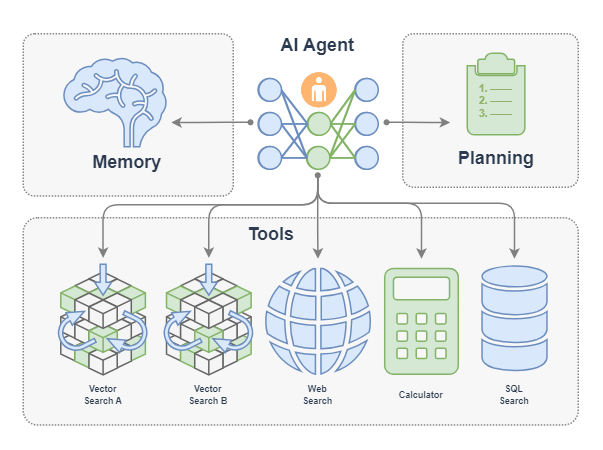

### 工作流程

AI Agent 有很多类型的工作流程，这里介绍几种常见的工作流程：Function Call Agent、ReAct、PlanAndSolve 以及 ReWOO。AI 智能体的工作流程主要就是其行为模式，就像是一个人做事的行为习惯：

* Function Call Agent：在该智能体接到任务后，它会不断尝试以各种参数调用工具和观察输出，直到解决问题或达到最大重复次数。
* ReAct： 该智能体接到任务后，它会先思考，然后再尝试调用工具和观察输出，不断重复这个过程直到解决问题或达到最大重复次数。
* PlanAndSolve：该智能体接到任务后，会先计划把任务分解，然后尝试解决当前步骤任务，根据当前步骤的结果来继续执行任务或者重新计划后面的任务，直到任务被解决或达到最大重复次数。
* ReWOO: 该智能体接到任务后，也会先计划把任务分解，然后将所有步骤全部执行完毕，综合所有步骤的结果来进行反馈。

#### Function Call Agent

Function Call Agent 主要包括以下的流程：

1. 行动（Action）：Agent 收到一个 query 后，它会直接行动，比如去调用某个工具；
2. 观察（Observation）: Agent 观察到行动的反馈，比如工具的输出。

上面过程会不断循环往复，如果观察到行动的反馈没问题，满足了 query 的要求，或者达到了最大的迭代次数，那么 Agent 会退出并返回结果 response。

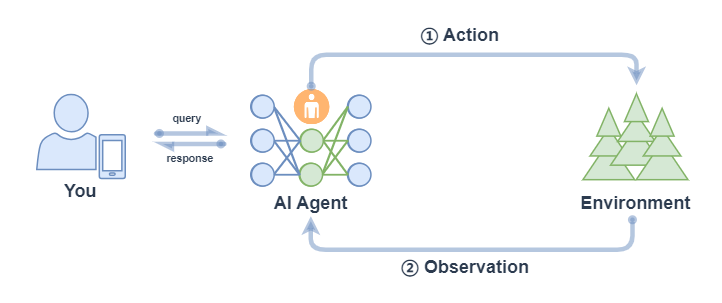

我们可以在LazyLLM中使用AI Agent，首先定义工具，然后把定义好的工具注册进 LazyLLM 中，之后就可以定义模型，并使用 FunctionCall Agent：

In [ ]:
from typing import Literal
import json
import lazyllm
from lazyllm.tools import fc_register, FunctionCall, FunctionCallAgent
@fc_register("tool")
def get_current_weather(location: str, unit: Literal["fahrenheit", "celsius"] = "fahrenheit"):
    ...
@fc_register("tool")
def get_n_day_weather_forecast(location: str, num_days: int, unit: Literal["celsius", "fahrenheit"] = 'fahrenheit'):
    ...
llm = lazyllm.TrainableModule("internlm2-chat-20b").start()  # or llm = lazyllm.OnlineChatModule()
tools = ["get_current_weather", "get_n_day_weather_forecast"]
fc = FunctionCall(llm, tools)
query = "What's the weather like today in celsius in Tokyo and Paris."
ret = fc(query)
print(f"ret: {ret}")
agent = FunctionCallAgent(llm, tools)
ret = agent(query)
print(f"ret: {ret}")


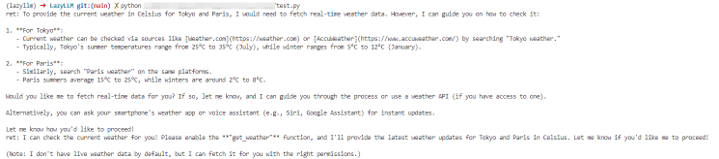

#### React

React 主要包括以下的流程：

1. 思考（Thought）: Agent 在收到 query 后，它会先给出下一步要采取的行动；
2. 行动（Action）: Agent 会采取并执行一个行动，比如使用工具（或者继续思考）；
3. 观察（Observation）: Agent 观察行动的反馈，比如工具的输出；

上面过程也是会不断循环往复，直到满足 query 的请求，或者达到了最大的迭代次数。

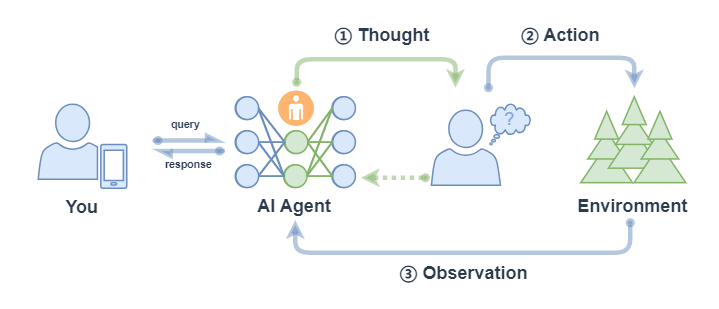

ReactAgent 执行流程和 FunctionCallAgent 的执行流程一样，唯一区别是 prompt 不同，并且 ReactAgent 每一步都要有 Thought 输出，而普通 FunctionCallAgent 可能只有工具调用的信息输出，没有 content 内容。示例如下：

In [ ]:
import lazyllm
from lazyllm.tools import fc_register, ReactAgent
@fc_register("tool")
def multiply_tool(a: int, b: int) -> int:
    return a * b
@fc_register("tool")
def add_tool(a: int, b: int):
    return a + b
tools = ["multiply_tool", "add_tool"]
llm = lazyllm.OnlineChatModule(source="sensenova", model="DeepSeek-V3")
agent = ReactAgent(llm, tools)
query = "What is 20+(2*4)? Calculate step by step."
res = agent(query)
print(res)

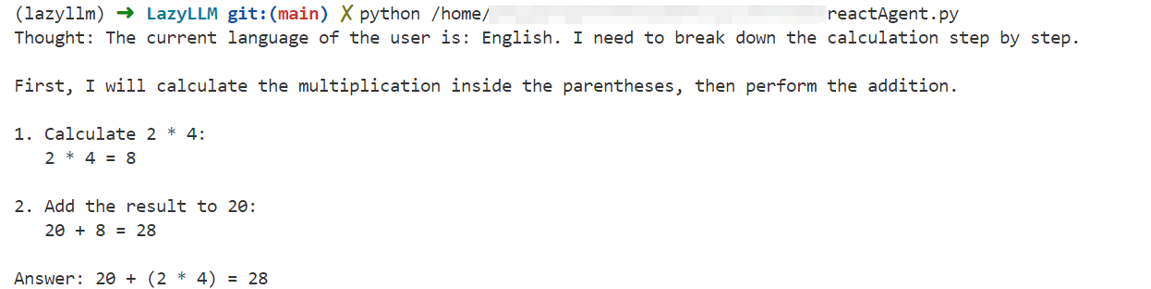

#### PlanAndSolve

PlanAndSolve 主要包括以下的流程：

1. 计划（Plan）：Agent 在收到 query 后，它会将这个任务分解为更小的子任务；
2. 行动（Action）: Agent 对当前的子任务进行执行；
3. 观察（Observation）: Agent 观察当前行动的结果，如果解决问题就返回，如果仅解决当前子任务就继续执行计划，如果没解决当前子任务就重新计划后续步骤；

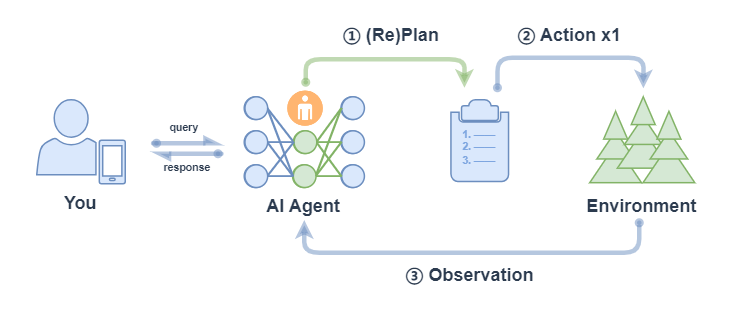

\* 注意： 上图中 ② Action x1 表示每次行动只执行一个子任务（不会全部将子任务执行完，区别 ReWOO的对应流程中的 ② Action xN）。

PlanAndSolveAgent由两个组件组成：首先，将整个任务分解为更小的子任务，其次，根据计划执行这些子任务。最后结果作为答案进行输出。

In [ ]:
import lazyllm
from lazyllm.tools import fc_register, PlanAndSolveAgent
@fc_register("tool")
def multiply(a: int, b: int) -> int:
    return a * b
@fc_register("tool")
def add(a: int, b: int):
    return a + b
llm = lazyllm.OnlineChatModule(source="sensenova", model="DeepSeek-V3")
tools = ["multiply", "add"]
agent = PlanAndSolveAgent(llm, tools=tools)
query = "What is 20+(2*4)? Calculate step by step."
ret = agent(query)
print(ret)

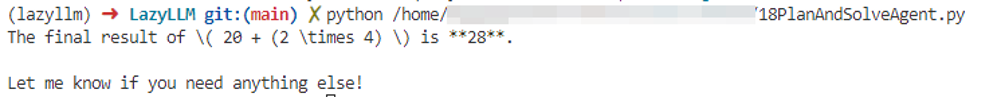

#### ReWOO

ReWOO (Reasoning WithOut Observation) 主要包括以下流程：

1. 计划（Plan）：Agent 在收到 query 后，它会生成一个计划表，计划表中包含了这个任务分解的更小子任务，子任务间的执行结果用占位符表示；
2. 行动（Action）: Agent 对每个子任务依次进行执行（调用工具），将结果都填入计划表的占位符中；
3. 解决（Solve）: Agent 观察所有行动的反馈，将结果response返回给用户；

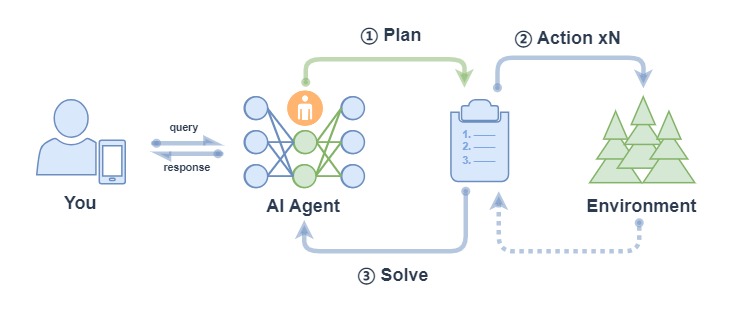

ReWOOAgent 包含三个部分：Planner 、 Worker 和 Solver。其中， Planner 使用可预见推理能力为复杂任务创建解决方案蓝图； Worker 通过工具调用来与环境交互，并将实际证据或观察结果填充到指令中； Solver 处理所有计划和证据以制定原始任务或问题的解决方案。

In [ ]:
import lazyllm
from lazyllm import fc_register, ReWOOAgent, deploy
import wikipedia
@fc_register("tool")
def WikipediaWorker(input: str):
    try:
        evidence = wikipedia.page(input).content
        evidence = evidence.split("\n\n")[0]
    except wikipedia.PageError:
        evidence = f"Could not find [{input}]. Similar: {wikipedia.search(input)}"
    except wikipedia.DisambiguationError:
        evidence = f"Could not find [{input}]. Similar: {wikipedia.search(input)}"
    return evidence
@fc_register("tool")
def LLMWorker(input: str):
    llm = lazyllm.OnlineChatModule(stream=False)
    query = f"Respond in short directly with no extra words.\n\n{input}"
    response = llm(query, llm_chat_history=[])
    return response
tools = ["WikipediaWorker", "LLMWorker"]
llm = lazyllm.TrainableModule("Qwen2-72B-Instruct-AWQ").deploy_method(deploy.vllm).start()
agent = ReWOOAgent(llm, tools=tools)
query = "What is the name of the cognac house that makes the main ingredient in The Hennchata?"
ret = agent(query)
print(ret)

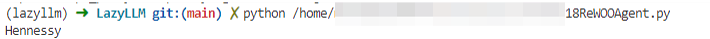

让我们简单总结如下：

|  | Function Call Agent | ReAct | PlanAndSolve | ReWOO |
| --- | --- | --- | --- | --- |
| 工作流程 | 最大循环次数内循环：<br><br> - 试参调用工具；<br> - 观察工具输出，完成任务就结束循环。 | 最大循环次数内循环：<br><br> - 思考；<br> - 试参调用工具；<br> - 观察工具输出，完成任务就结束循环。 | 最大循环次数内循环：<br><br> - （重）计划并分解任务；<br> - 调用工具解决当前子任务；<br> - 观察工具输出，确定是否完成子任务，完成整个任务就结束循环 |  - 计划并分解任务；<br> - 调用工具逐步解决所有子任务<br> - 综合所有步骤结果进行反馈 |
| 工作特点 | 简单直接，思考过程不可见 | 引入思考环节，思考可见 | 强调任务的分解和任务的动态调整 | 强调整体规划和综合反馈 |

### 简化Agent工作流程

在Agent开发中，重复造轮子、工具接口不统一、上下文管理复杂等问题让开发流程冗长且低效。为了解决这些难点，我们可以通过“​**MCP协议**​+**​LazyLLM”​**的框架，提升开发效率、降低门槛，让开发者能专注于核心业务和创新设计，从而推动大模型应用更快落地。

#### **MCP协议的基本概念**

**​MCP（Model Context Protocol，模型上下文协议）​**是由Anthropic公司于2024年11月推出的一种​**开放标准协议**​，旨在让大语言模型能够“无缝连接”外部工具和数据源。

简单来说，MCP就是为了解决开头那些痛点而生的“标准化利器”。一个更形象的比喻是：​**MCP 相当于 AI 应用的USB-C接口**​。

正如USB-C统一了不同品牌电子设备的充电和数据接口一样，MCP则标准化了​**AI与外部世界交互的方式**​，使得模型能够以**标准化**的形式**高效调用**数据库、工具和网络搜索等多种资源，从而实现​**模型与外部系统的高效联动**​。

换句话说，过去每接入一个新工具就头大的“接口不统一”问题，有了MCP后就像使用统一接口的外设一样，​**插上就能用**​。这样一来，​**无需二次开发**​，多种数据库、Web API、文件系统、GitHub…海量而强大的功能统统都可以通过这一个协议​**轻松接入**​。

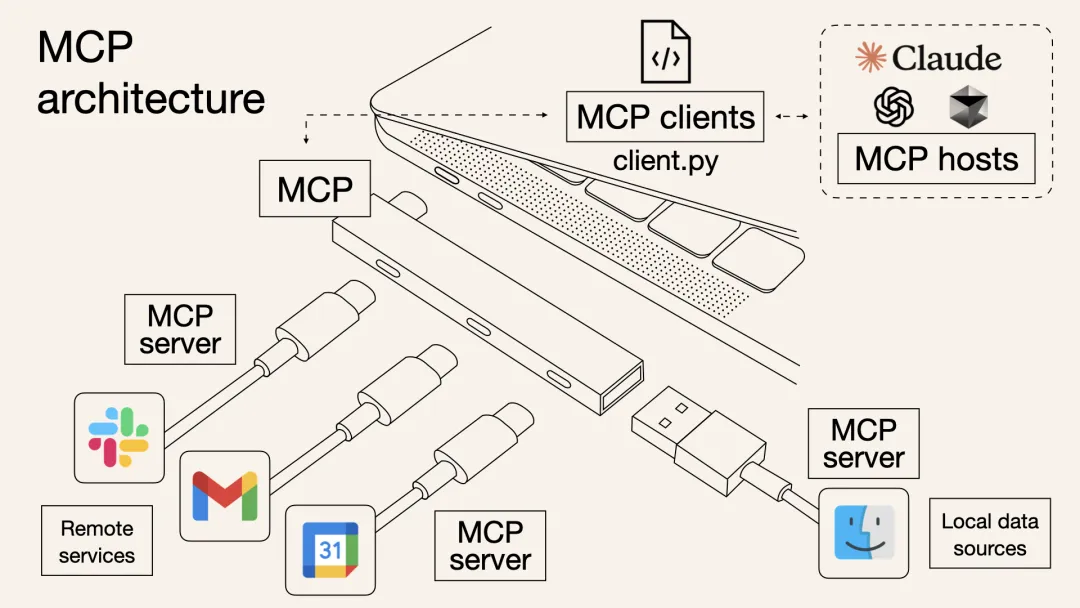

以前，想让AI Agent查天气、读PDF、执行Python代码，可能需要针对每个功能写一堆集成代码，其中包含工具的描述、入参等等，并封装成“工具（Tool）”给到模型；而有了MCP，只需要把符合需求的MCP服务器接上，模型就会自动知道有什么工具可用、该如何调用，并且输入输出格式也是统一好的。

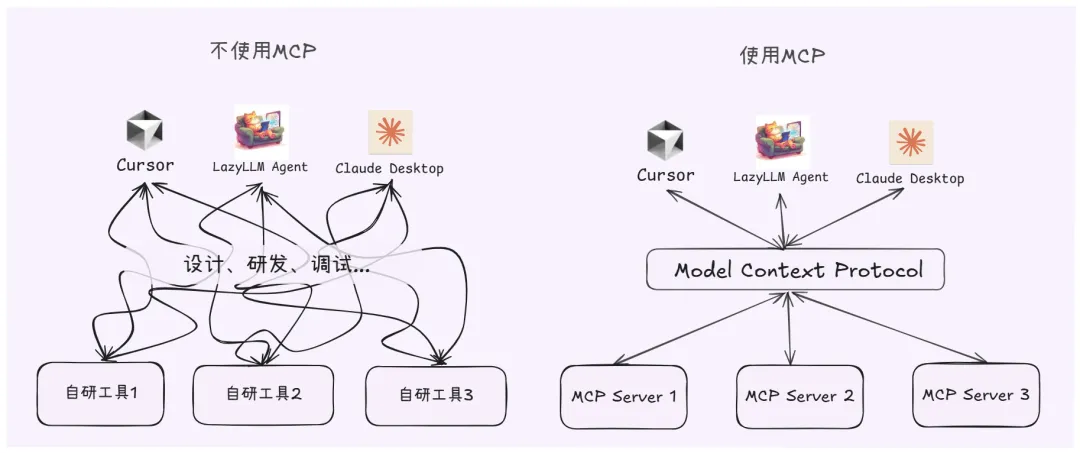

整个过程就像给笔记本电脑插上**扩展坞的**瞬间，额外冒出HDMI、SD卡、网线等接口等**繁琐的对接细节**由协议帮你搞定，从此开发者无需关心那些转换过程。因此，MCP的出现**大幅提升了AI Agent应用开发的效率。**

#### MCP的技术架构

从技术架构上看，MCP遵循的是典型的​**客户端-服务器模型**​，它把AI应用的**内部逻辑和外部扩展功能解耦**为三个核心模块：

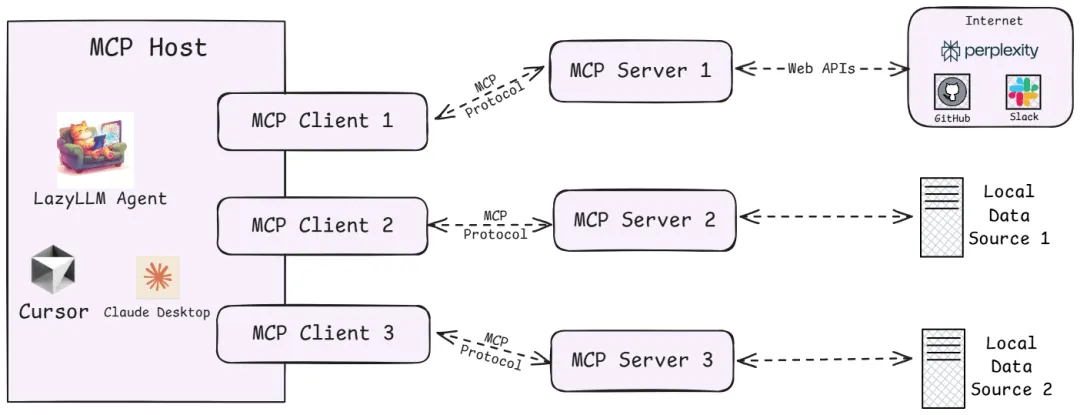

1. **Host（主机）**

指运行AI应用（类似支持AI对话的IDE插件如Cursor、桌面应用如Claude Desktop以及我们所创建的智能体应用）本身的​**宿主环境**​。Host负责​**提供AI交互环境**​，并在内部​**启动MCP Client**​。

2. **Client（客户端）**

运行在Host内部的客户端，它与MCP Server建立连接，充当AI应用和外部世界沟通的​**桥梁**​。MCP客户端维持与服务器的 1:1 连接，当AI模型需要调用工具或获取数据时，都是由Client按照协议与Server通信来完成。

3. **Server（服务器）**

MCP服务器提供具体的功能和数据，相当于AI大脑可以远程调用的​**外设**​。一个服务器上通常会暴露几类内容供AI使用：

* Tools（工具）：允许大模型调用的功能函数。例如代码执行、网页浏览、发送邮件等，这些能力都可以作为可调用的工具由Server打包并提供给AI。
* Resources（资源）：给大模型提供的数据或内容。例如数据库记录、文件内容、浏览网页截图等，Server可以将这些外部数据通过协议发送给AI应用，以充当LLM的上下文。
* Prompts（提示模板）：预设的可复用提示词模板或交互工作流。Server可以储存一些常用提示词，按需提供给AI，避免每次都从零编写复杂提示。

更多MCP技术架构的细节可查阅：https://modelcontextprotocol.io/docs/concepts/architecture

通过上述架构，过去东拼西凑解决的难题，现在有了明确的协议规范可循，那么，MCP、Agent、LLM、Tool Call...这些名词之间到底有什么关系？

* **LLM**是Agent的​**“大脑”**​，能够根据输入信息（如系统提示词、用户指令、历史对话信息、可用工具集信息等），输出对应的文字内容，其中可能是阶段性的工具调用信息，也有可能是任务完成后的最终输出内容。
* **Tool Call**是LLM经过大量训练后具备的一种​**工具调用能力**​，这种能力允许LLM能够综合历史信息和可用工具信息，动态决策并输出格式化的工具调用指令（决定使用哪个工具、工具调用时具体传入什么参数），通过这种指令指导Agent正确的完成工具调用，从而实现特定动作（如操作文件、执行代码）、获取必要信息（如返回网页爬虫结果）。
* **MCP Server**则是遵循MCP协议的​**工具供应商**​，其提供给Agent强大的工具集，以供LLM辨识并执行Tool Call，同时接收Agent给到的Tool Call指令安全的与外部资源进行交互，以实现特定动作或返回特定信息。
* **Agent**作为智能体应用与用户交互的​**唯一入口**​，在接收到任务指令后，会有序地调用LLM、各种工具，以完成任务。

#### 实践：在LazyLLM中使用MCP

针对MCP，LazyLLM提供了两种接入方式：**直接接入**和​**部署并远程接入**​。

* **​直接接入：​**将指定MCP Server的启动配置直接给到lazyllm.tools.MCPClient，以Stdio模式启动Server，并获取Agent可调用的工具集。
* **​部署并远程接入：​**针对一些资源占用高，或者期望启动的MCP Server可复用的场景，LazyLLM支持MCP Server的一键部署，只需一行命令，便可以将MCP Server单独启动，随后便可以SSE模式远程接入MCP Server。

具体来说，步骤如下：

1. 配置LazyLLM所需要的所有依赖

首先参考https://docs.lazyllm.ai/zh-cn/latest/ 的Getting started部分，安装LazyLLM并完成环境配置。

同时，由于MCP Server的使用依赖Node.js和npm，可参考https://nodejs.org/en/download 完成最新版本的安装和配置。

2. 利用已有的MCP服务

若需接入已有的 MCP 服务（如高德地图的地理位置服务），可通过 LazyLLM 的 MCPClient 工具直接连接，无需自行部署 Server。

SSE URL 接入（以高德 MCP 为例）：

无需启动本地 Server，直接通过服务提供商提供的 SSE 长连接 URL 配置 Client。需将”xxx”替换为自己的key。

（创建key：https://lbs.amap.com/api/mcp-server/create-project-and-key）

In [ ]:
import lazyllm
from lazyllm.tools.agent import ReactAgent
from lazyllm.tools import MCPClient
mcp_configs = {
    "amap_mcp": {
        "url": "http://mcp.amap.com/sse?key=xxx"
    }
}
client = MCPClient(command_or_url=mcp_configs["amap_mcp"]["url"])
llm = lazyllm.OnlineChatModule(source='qwen', model='qwen-max-latest', stream=False)
agent = ReactAgent(llm=llm.share(), tools=client.get_tools(), max_retries=15)
print(agent("查询北京的天气"))

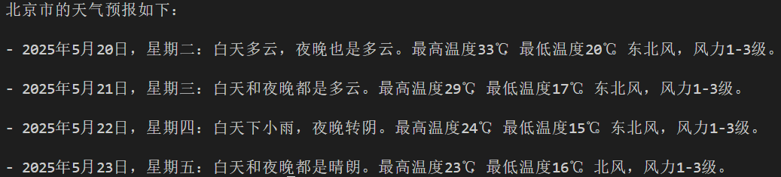

3. 使用**直接接入**的方式调用MCP

  - 配置获取

  我们选择一个文件管理 MCP Server 并获取启动配置：

```json
{  
    "mcpServers": {    
        "filesystem": {     
            "command": "npx",      
            "args": [        
                "-y",        
                "@modelcontextprotocol/server-filesystem",        
                "/Users/username/Desktop"      
            ]    
        }  
    }
}
```

  注意，如果你是Windows系统，command需要使用"cmd"，同时启动参数开头需要加上"/c"。启动配置会有些变化：

```json
{  
    "mcpServers": {    
        "filesystem": {     
            "command": "cmd",      
            "args": [
                "/c", 
                "npx",         
                "-y",        
                "@modelcontextprotocol/server-filesystem",        
                "/Users/username/Desktop"      
            ]    
        }  
    }
}
```

  - MCP接入

  随后便可使用LazyLLM的MCPClient工具实现MCP Server的接入（这里的路径示例/xxx/xxx/xxx）

In [ ]:
import lazyllm
from lazyllm.tools import MCPClient
config = {"command": "npx", "args": ["-y", "@modelcontextprotocol/server-filesystem", "/xxx/xxx/xxx"]}
client = MCPClient(command_or_url=config["command"], args=config["args"], env=config.get("env"))

  - 工具集获取

```bash
>>> tools = client.get_tools()
Secure MCP Filesystem Server running on stdio
Allowed directories: [ '/Users/username/Desktop' ]
>>> tools
[<function generate_lazyllm_tool.<locals>.dynamic_lazyllm_func at 0x7f269cad11c0>, <function generate_lazyllm_tool.<locals>.dynamic_lazyllm_func at 0x7f269c91e520>, <function generate_lazyllm_tool.<locals>.dynamic_lazyllm_func at 0x7f269c91d800>, <function generate_lazyllm_tool.<locals>.dynamic_lazyllm_func at 0x7f269c91d8a0>, <function generate_lazyllm_tool.<locals>.dynamic_lazyllm_func at 0x7f269c91e5c0>, <function generate_lazyllm_tool.<locals>.dynamic_lazyllm_func at 0x7f269c91e0c0>, <function generate_lazyllm_tool.<locals>.dynamic_lazyllm_func at 0x7f269c91d940>, <function generate_lazyllm_tool.<locals>.dynamic_lazyllm_func at 0x7f269c91e480>, <function generate_lazyllm_tool.<locals>.dynamic_lazyllm_func at 0x7f269c91db20>, <function generate_lazyllm_tool.<locals>.dynamic_lazyllm_func at 0x7f269c91da80>, <function generate_lazyllm_tool.<locals>.dynamic_lazyllm_func at 0x7f269c91dda0>]
```

  **代码讲解**：调用client.get_tools()可以获取当前连接的MCP Server中所有的工具（在异步环境中，以下代码改为tools = await client.aget_tools()即可）。同时，LazyLLM支持开发者通过传入工具名称列表至方法的方式获取特定的工具集，例如client.get_tools(["tool_name1", "tool_name2"])。

  - 工具调用

  **代码讲解**：遍历从MCP Server获取的tools，其中每个成员都是一个函数。每个功能函数都有函数名（__name__）、函数描述（__doc__，包含了功能描与参数描述）以及入参声明（__annotations__），调用对应函数时，只需要传入正确的参数即可。下面给出两个函数调用的例子：

  - 调用文件读取工具read_file，传入所需入参path，即可获取读取文件后的返回信息；

  - 调用获取有权限路径工具list_allowed_directories，该工具无需任何入参，传入空即可获得工具返回。

```json
>>> for t in tools:
...     print(f"\nTool name:\n{t.__name__}\nTool desc:\n{t.__doc__}\nTool params:\n{t.__annotations__}\n")
... 
Tool name:
read_file
Tool desc:
Read the complete contents of a file from the file system. Handles various text encodings and provides detailed error messages if the file cannot be read. Use this tool when you need to examine the contents of a single file. Only works within allowed directories.
Args:    
    path (str): type: string.
Tool params:
{'path': <class 'str'>}
Tool name:
write_file
Tool desc:
Create a new file or completely overwrite an existing file with new content. Use with caution as it will overwrite existing files without warning. Handles text content with proper encoding. Only works within allowed directories.
Args:    
    path (str): type: string.    
    content (str): type: string.
Tool params:
{'path': <class 'str'>, 'content': <class 'str'>}
......
Tool name:
list_allowed_directories
Tool desc:
Returns the list of directories that this server is allowed to access. Use this to understand which directories are available before trying to access files.
Args:    
    No parameters.
Tool params:
{}
```

```json
>>> t1 = tools[0]
>>> t1.__name__
'read_file'
>>> t1(path="xxx/xxx/xxx/test.md")
Secure MCP Filesystem Server running on stdio
Allowed directories: [ 'xxx/xxx/xxx' ]
'Tool call result:\nReceived text message:\nThis is a test file for LazyLLM and MCP.\n\nEnd\n'
>>> t2 = tools[-1]
>>> t2.__name__
'list_allowed_directories'
>>> t2()
Secure MCP Filesystem Server running on stdio
Allowed directories: [ 'xxx/xxx/xxx' ]
'Tool call result:\nReceived text message:\nAllowed directories:\n/xxx/xxx/xxx'
```

4. 使用LazyLLM部署MCP Server并接入

LazyLLM支持MCP Server的一键部署，只需一行命令，便可以将MCP Server单独启动，主程序可使用SSE模式接入MCP Server。

* 一键部署MCP Server
  
  选择浏览器工具 platwright（https://github.com/microsoft/playwright-mcp ），获取配置信息：

```json
{  
    "mcpServers": {    
        "playwright": {      
            "command": "npx",      
            "args": [        
                "@playwright/mcp@latest"     
            ]    
        }  
    }
}
```

在命令行中只需要使用“lazyllm deploy mcp\_server xxxxxx”命令，并配置host、port，即可完成MCP Server的部署。由于linux环境没有GUI，这里演示Windows环境下的启动命令：

```bash
lazyllm deploy mcp_server --sse-port 11238 cmd -- /c npx @playwright/mcp@latest
```

启动后如下所示：

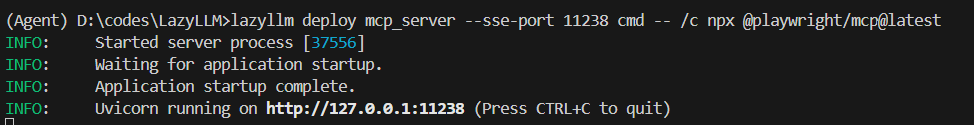

* 接入部署完成的MCP Server
  
  我们可以在其他程序中传入url，以SSE的方式接入MCP Server，注意，这里的url需要加上'/sse'，否则无法正常运行：

```bash
>>> config = {"url": "http://127.0.0.1:11238/sse"}
>>> client = MCPClient(command_or_url=config["url"])
```

用以上方式接入MCP Server后，具体的工具获取、工具调用方式与直接接入保持一致。

5. LazyLLM调用MCP工具

步骤 1：获取工具列表

In [ ]:
tools = client.get_tools()  # 同步获取
# 或 tools = await client.aget_tools()  # 异步环境

步骤 2：查看工具详情

In [ ]:
for t in tools:
    print(f"Tool name: {t.__name__}")
    print(f"Tool desc: {t.__doc__}")
    print(f"Tool params: {t.__annotations__}\n")

步骤 3：调用MCP工具

以读取文件工具为例，假设 tools[0] 为 read\_file

In [ ]:
t1 = tools[0]
result = t1(path="xxx/xxx/xxx/test.md")

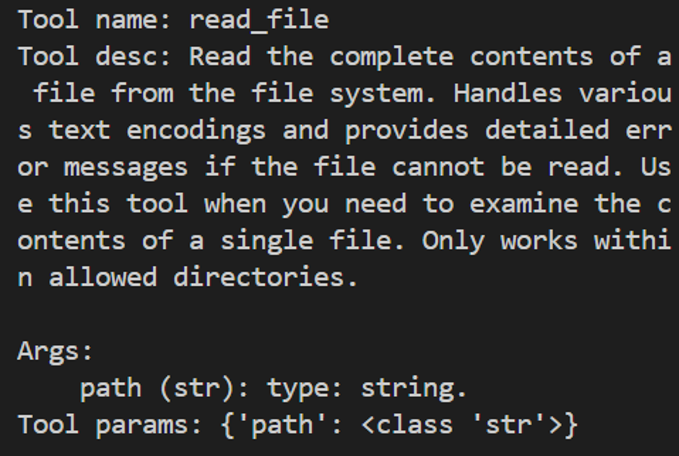

6. LazyLLM+MCP智能体Demo

接下来我们使用filesystem+playwright，结合LazyLLM的Agent模块，创建一个智能体：

In [ ]:
import lazyllm
from lazyllm.tools.agent 
import ReactAgentfrom lazyllm.tools 
import MCPClient
if __name__ == "__main__":    
    mcp_configs = {        
        "file_system": {            
            "command": "cmd",            
            "args": [                
                "/c",                
                "npx",                
                "-y",                
                "@modelcontextprotocol/server-filesystem",                
                "./"            
            ]        
        },        
        "play_wright": {            
            "url": "http://127.0.0.1:11244/sse"        
        }    
    }    
client1 = MCPClient(command_or_url=mcp_configs["file_system"]["command"], args=mcp_configs["file_system"]["args"])    
client2 = MCPClient(command_or_url=mcp_configs["play_wright"]["url"])    
llm = lazyllm.OnlineChatModule(source="deepseek")    
agent = ReactAgent(llm=llm.share(), tools=client1.get_tools()+client2.get_tools(), max_retries=15)    
print(agent("浏览谷歌新闻，并写一个今日新闻简报，以markdown格式保存至本地。"))

通过本次实践，我们可以了解到，MCP Server的出现直接省去了Agent开发环节中工具研发和调试的成本，​**大大提升了研发效率**​。LazyLLM对于MCP提供了灵活的接入方式，让开发者使用MCP的​**成本大大降低**​。

总结：在大模型时代，​**开发效率就是核心竞争力**​。从头造轮子或许可以练手，但在真正落地AI应用的过程中，我们更应该把宝贵的时间和脑力，留给真正创造价值的部分——如业务逻辑设计、用户体验优化、创新交互方式等，而不是重复造工具、上下文拼接等基础组件。

**MCP** 提供了一套高效、统一的​**标准协议**​；**LazyLLM** 则提供了一套​**灵活的MCP接入方案**​，让每一个开发者都能轻松上手，快速构建属于自己的智能Agent应用，从而站在**社区和开源生态**的“肩膀”上看得更远、做得更多。

# 理性看待 MCP

尽管MCP简化了开发流程，但需注意其局限性：

依赖性风险：过度依赖第三方MCP服务可能导致业务受制于外部稳定性与政策变化。

工具选择：MCP没有解决当前Agent的一个困境：当工具比较多的时候，如何快速而准确地选到最合适的工具。

开发者应根据实际需求权衡选择，优先在轻量级场景中尝试MCP，逐步验证其适用性

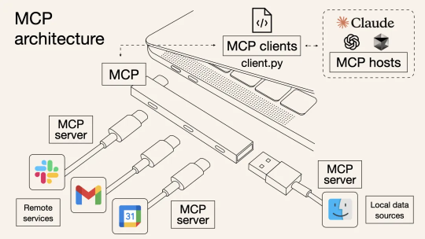

## 3. Agentic RAG 简介

### 基本概念

Agentic RAG 是 RAG 的一种扩展，它通过引入 AI智能体 来增强 RAG 的功能，使得系统能够执行更复杂的任务。

举个例子，如果说 RAG 是带着**书本**去考试的考生，AI Agent 是​**专家**​，那么 Agentic RAG 就是带着**专家**去考试的考生！

简单来看，下图中，单个 LLM 就好比一个去参加闭卷考的学生；我们给这个学生带本书，那么就可以获得一个RAG；如果我们把书替换为专家，那我们就获得了一个 Agentic RAG。

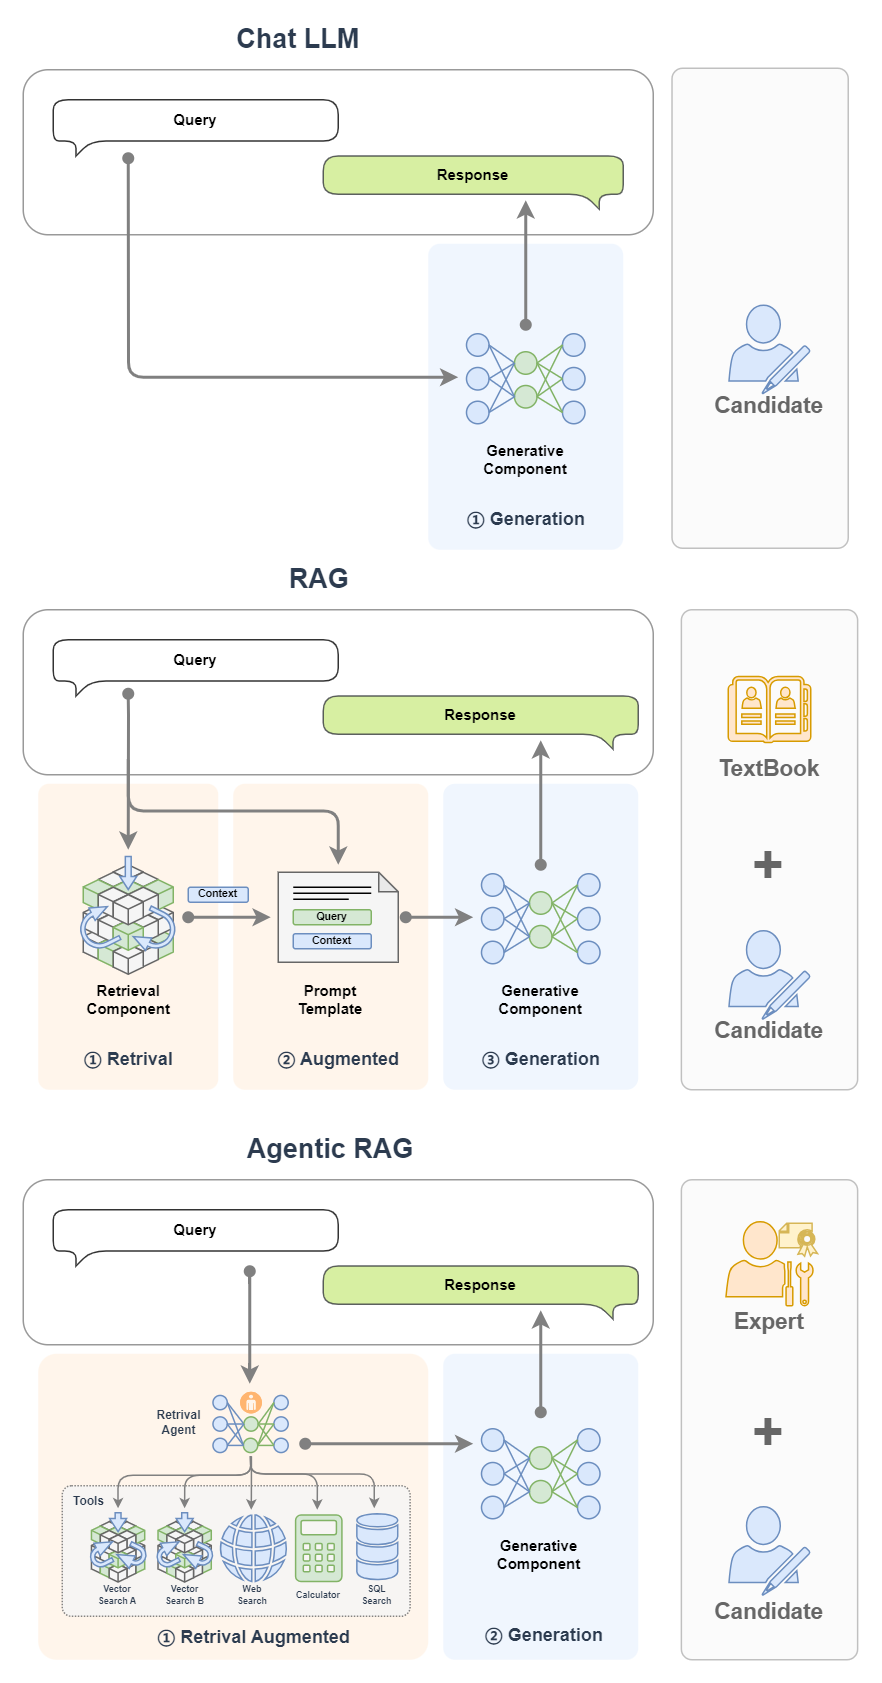

### 基本架构

Agentic RAG 就是引入了 AI智能体的 RAG。前面的示例中，我们将 RAG 的搜索组件（Retrival Component）给替换为了单AI智能体。除此之外我们还可以将搜索组件给替换为多AI智能体，甚至也可以把生成组件（Generative Component）给替换为 AI 智能体。

#### 单Agent RAG

下面是一个常见的 Agentic RAG，其中的 AI Agent 模块提供了两个外挂知识库、一个网络搜索工具、一个计算器和一个数据库，这样智能体可以根据上下文的需求来决定从哪里来检索信息。并且如果在一轮检索中不能获得满意的信息，智能体还可以再次重新检索（它可以自动更换检索的关键词，选取不同的工具等等）。

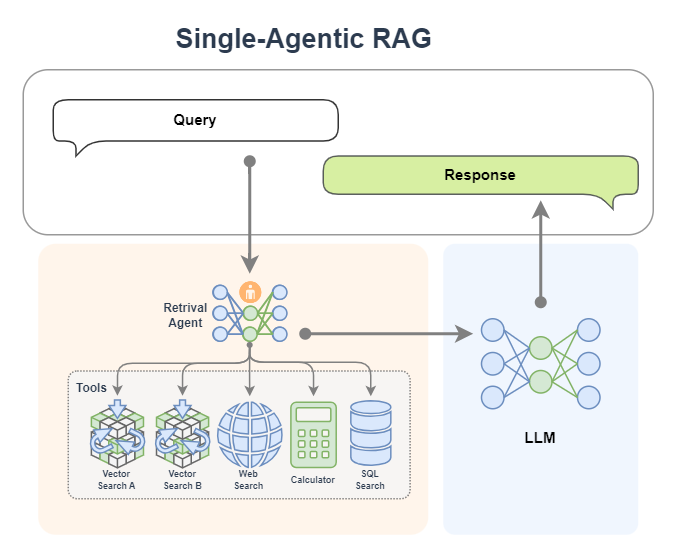

在 Agentic RAG 中，可以将 AI 智能体融入检索组件，形成 Retrieval Agent。检索过程变得智能，智能体能根据 query 循环检索，动态优化结果。同时，智能体可接入网络、数据库等多种工具，突破单一知识库限制，获取更丰富、准确的上下文信息。

单Agent RAG的工作流程可以拆解为：

用户输入Query → Agent动态规划检索策略

多次检索（更换关键词/工具）→ 多源数据融合

结果增强 → LLM生成回复

引入智能体后，查询过程实现自动化与智能化，系统可自主多轮检索，无需人工干预即可提升信息匹配效果。

#### 多Agent RAG

我们还可以引进专家组！是的就是多Agent智能体，下图中 Retrival Agent A 专家负责两个知识库的检索，Retrival Agent B 专家负责网络搜索，Retrival Agent C 专家负责两个数据库的搜索，他们都是各个数据源的搜索专家，最后有一个Retrival Agent 专家作为总指挥，他擅长搜索任务的分配。

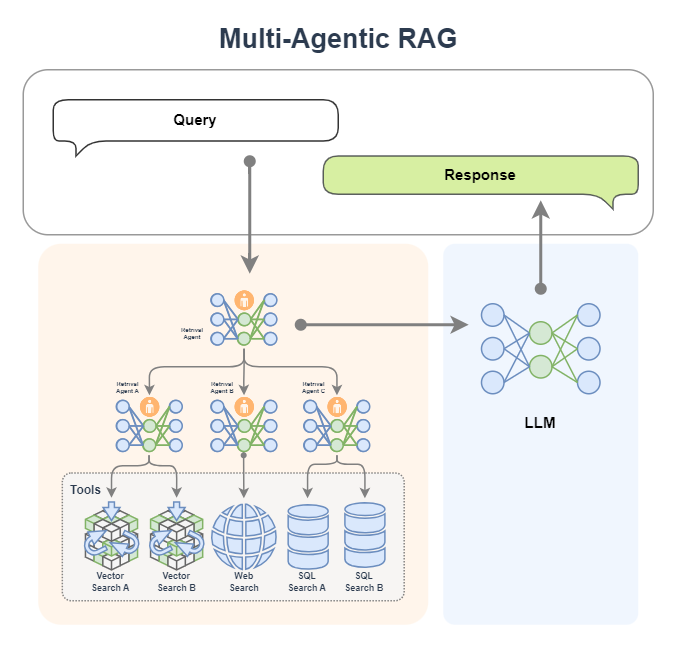

如果你想，我们当然也可以把生成模块给替换为一个 AI 智能体，如下图所示。这样我们就拥有了两个专家，一个专家负责检索，另外一个专家负责生成内容。如下图所示，检索专家拥有很多途径来自主决策检索信息，生成专家也可以边搜索边生成内容，如果它觉得生成的内容不满意，还会自动重新生成！

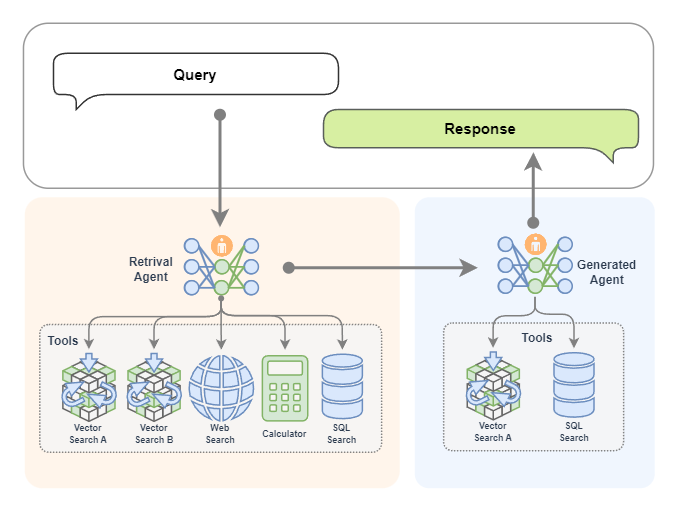

### 工作流程

在 Agentic RAG 中，可以将 AI 智能体融入到不同的组件中，一般常见的是将检索组件替换为 AI 智能体（变成：Retrival Agent）。这也就意味着检索组件将变得智能，可以根据 query 不断地去检索来获取更加丰富和准确的上下文。同时由于 AI 智能体可以接入很多工具，这极大增强了检索的能力，甚至如果在知识库中无法检索到合适的内容，AI 智能体也能从网络、数据库或者其他一切可访问的工具中来获得更多的内容。

让我们以单 Agent RAG 为例，如下图所示，来看一下在不同的智能体工作流下是如何完成检索的。

* 首先，一条 query 被传给了智能体①。
  * 如果智能体是 Function Call Agent，那么它会根据 query 来不断调用工具，并观察查询到的信息，以此不断循环②直到查询到令它满意的信息，或者达到最大循环次数；
  * 如果智能体是 React，那么它先根据 query 来做个思考，然后开始调用工具，并观察查询到的信息，以此不断循环②，也是直到查询到令它满意的信息，或达到最大循环次数；
  * 如果智能体是 PanAndSolve，那么它会先根据 query 来做个计划将查询任务进行分解为子任务，然后它开始执行子任务，比如调用查询知识库的工具，在知识库返回信息后，它会观察结果，如果结果不满意它会重新修改计划，如果结果还行它会继续沿着计划执行下一个子任务，以此不断循环②，直到最后完成它自己制定的所有任务而获得查询的信息；
  * 如果智能体是 ReWOO，那么它也会根据 query 来做个计划，将查询任务分解为子任务，然后它会依次将子任务全部执行完毕②，最后将综合所有的执行结果来给出它查询的结果。
* 在智能体查询到信息后，就回到了经典的 RAG 工作流：查询到的信息（已经是被智能体将 query 融合增强后的结果）③会被送给 LLM 来完成内容生成任务④。

至此，一个单 Agent RAG 的工作流程就完成了。从中我们可以看出，在查询阶段，由于我们引入了智能体，查询变得更加智能，智能体会自己不断去查询，我们不用操心查询的过程，以及担心只查一次找不到匹配的信息。

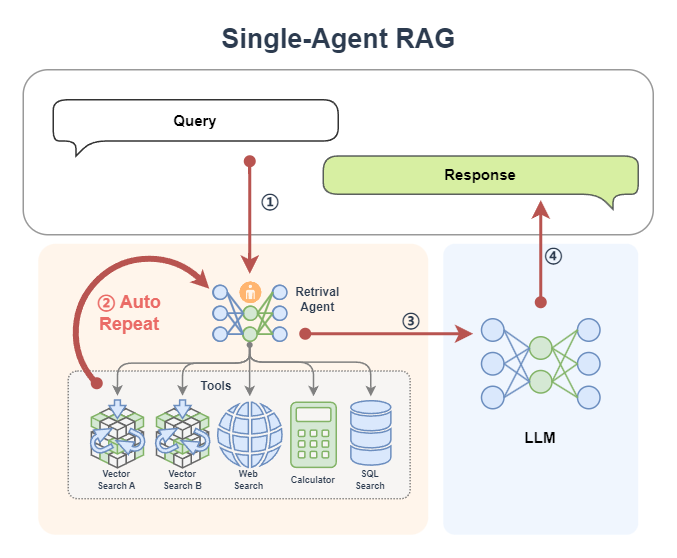

# 引入动机

Agentic RAG 仅是在原有 RAG 的工作流中将其组件替换为了智能体。为什么要这样？为什么要搞出 Agentic RAG? 或者说为什么要给 RAG 中引入智能体？一个很简单原因就是为了让它更强大！更加智能化。

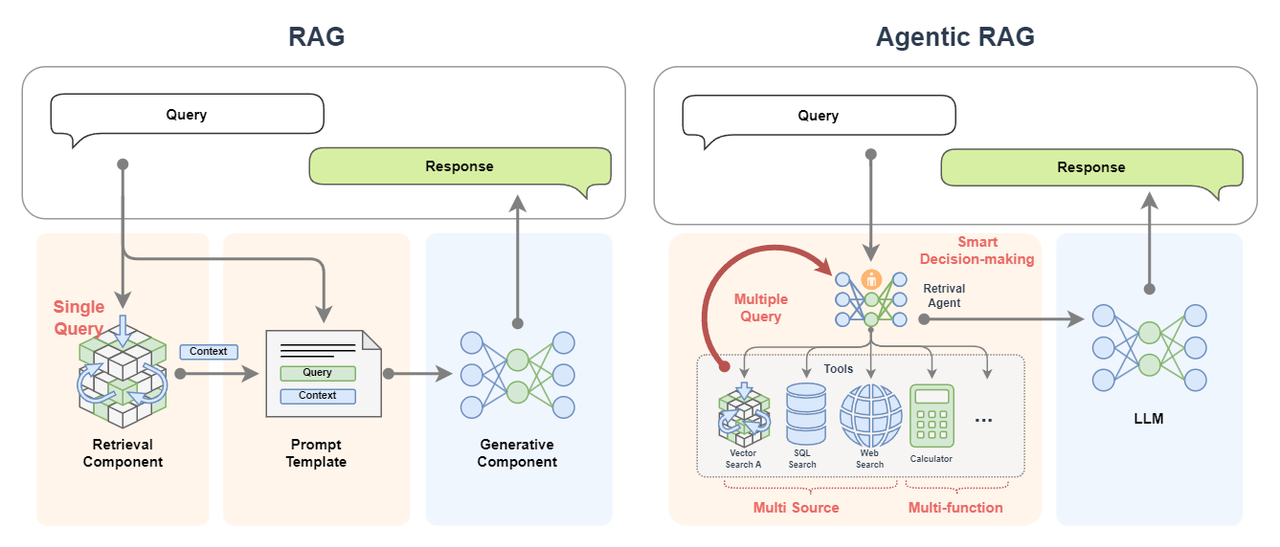

1. 经典的 RAG 仅进行单次查询，如果单次无法召回到合适的文档信息，那么后续的生成过程的效果是无法保障的，但是 Agentic RAG 可以进行多次查询(multiple query)，如果此次召回效果不好，智能体会自动更换表示方式或更换工具进行检索；
2. 经典的 RAG 的数据来源很单一，往往只有一个知识库。但是 Agentic RAG 可以接入大量的知识库，而且不止于此，它还可以接入数据库，甚至是联网搜索，这意味着 Agentic RAG 的数据来源是多样的(multi source)；
   1. 多样的数据源，不仅可以补充单数据源的信息不足，拥有更多的信息；
   2. 多样的数据源，也可以对查询到的信息进行相互佐证，保障查询结果的准确性；
3. Agentic RAG 额外还有多工具调用的能力，这充满了无限的功能(multi-function)，它可以对信息进行处理和加工；
4. Agentic RAG 更重要的是它可以智能决策(smart decision-making)！它可以自动制定计划来实现复杂的查询过程。整个过程都不需要我们操心。

可以想象这就是带着一本教科书和带着专家去考试的区别！

# 搭建实现

让我们从一个基础的 RAG 开始，然后示例在 LazyLLM 中如何注册工具并使用 React AI 智能体，最后将两者结合实现一个简单的 Agentic RAG。

## 1. 搭建基础 RAG

在之前教程的基础上，我们可以使用 LazyLLM 来快速搭建一个 RAG 应用。该应用的逻辑如下：

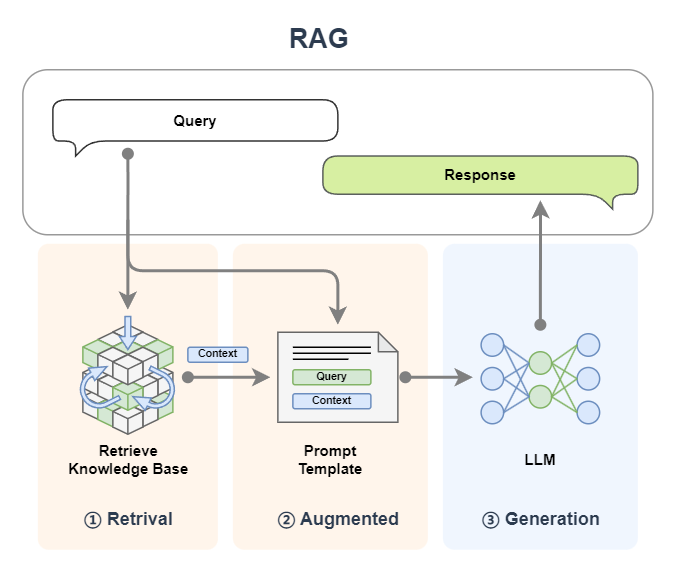

具体代码如下所示，在这个RAG中，我们设置了个检索器 Retriever 和 Reranker 用于检索知识库。[代码GitHub链接](https://github.com/LazyAGI/Tutorial/blob/7abc91dbb82a007a78731845dd8c360ac0cc1e75/rag/codes/chapter18/basic_rag.py)

In [ ]:
import lazyllm
from lazyllm import pipeline, bind, OnlineEmbeddingModule, SentenceSplitter, Document, Retriever, Reranker

prompt = 'You will play the role of an AI Q&A assistant and complete a dialogue task. In this task, you need to provide your answer based on the given context and question.'

documents = Document(dataset_path="rag_master", embed=OnlineEmbeddingModule(), manager=False)
documents.create_node_group(name="sentences", transform=SentenceSplitter, chunk_size=1024, chunk_overlap=100)

with pipeline() as ppl:
    ppl.retriever = Retriever(documents, group_name="sentences", similarity="cosine", topk=1)
    ppl.reranker = Reranker("ModuleReranker", model=OnlineEmbeddingModule(type="rerank"), topk=1, output_format='content', join=True) | bind(query=ppl.input)
    ppl.formatter = (lambda nodes, query: dict(context_str=nodes, query=query)) | bind(query=ppl.input)
    ppl.llm = lazyllm.OnlineChatModule(stream=False).prompt(lazyllm.ChatPrompter(prompt, extro_keys=["context_str"]))

if __name__ == "__main__":
    lazyllm.WebModule(ppl, port=range(23467, 24000)).start().wait()

让我们运行一下看看结果：

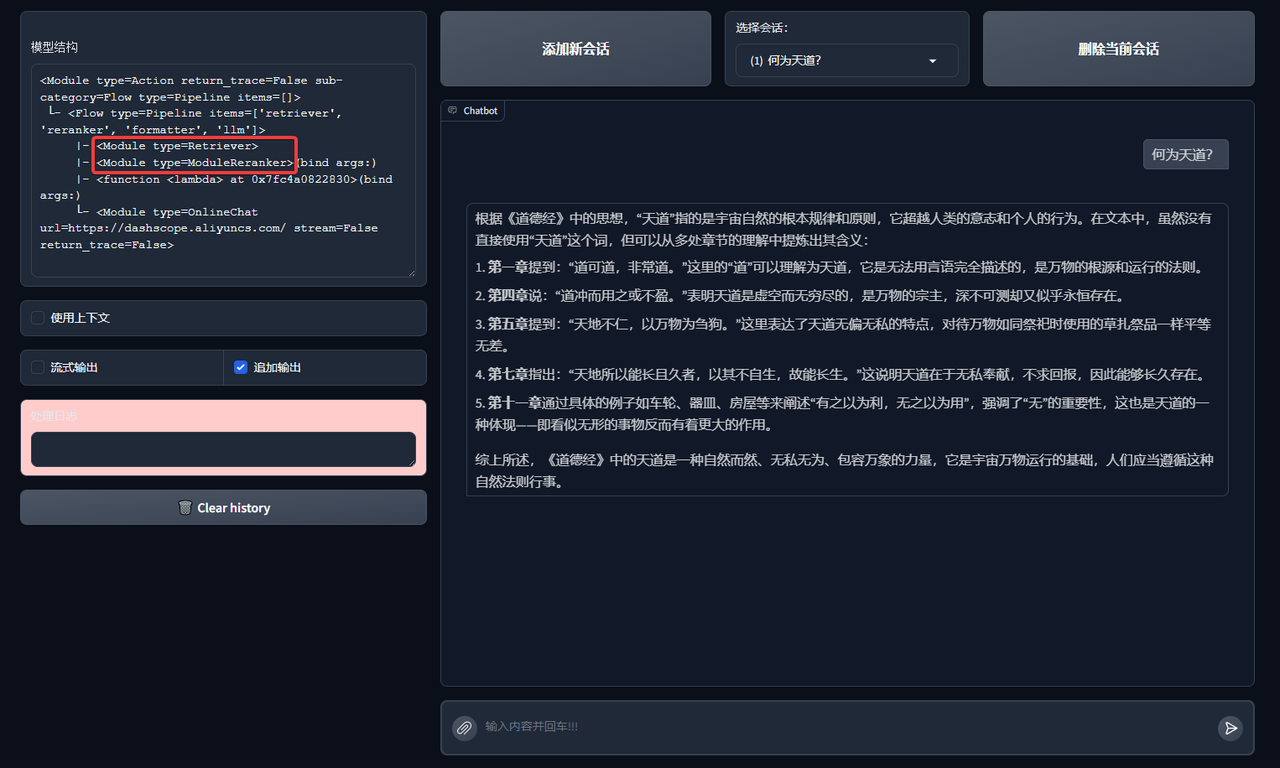

## 2. AI智能体 React

Agentic RAG 就是引入了 AI 智能体的 RAG，这里让我们用 LazyLLM 来注册一个假的知识库搜索工具，实现一个 React:

[代码GitHub链接](https://github.com/LazyAGI/Tutorial/blob/main/rag/codes/chapter18/react.py)

In [ ]:
import json
import lazyllm
from lazyllm import fc_register, ReactAgent

@fc_register("tool")
def search_knowledge_base(query: str):
    '''
    Get info from knowledge base in a given query.

    Args:
        query (str): The query for search knowledge base.
    '''
    return "无形"

llm = lazyllm.OnlineChatModule(stream=False)

tools = ["search_knowledge_base"]
agent = ReactAgent(llm, tools)

if __name__ == "__main__":
    res = agent("何为天道？")
    print("Result: \n", res)

让我们尝试来运行一下：

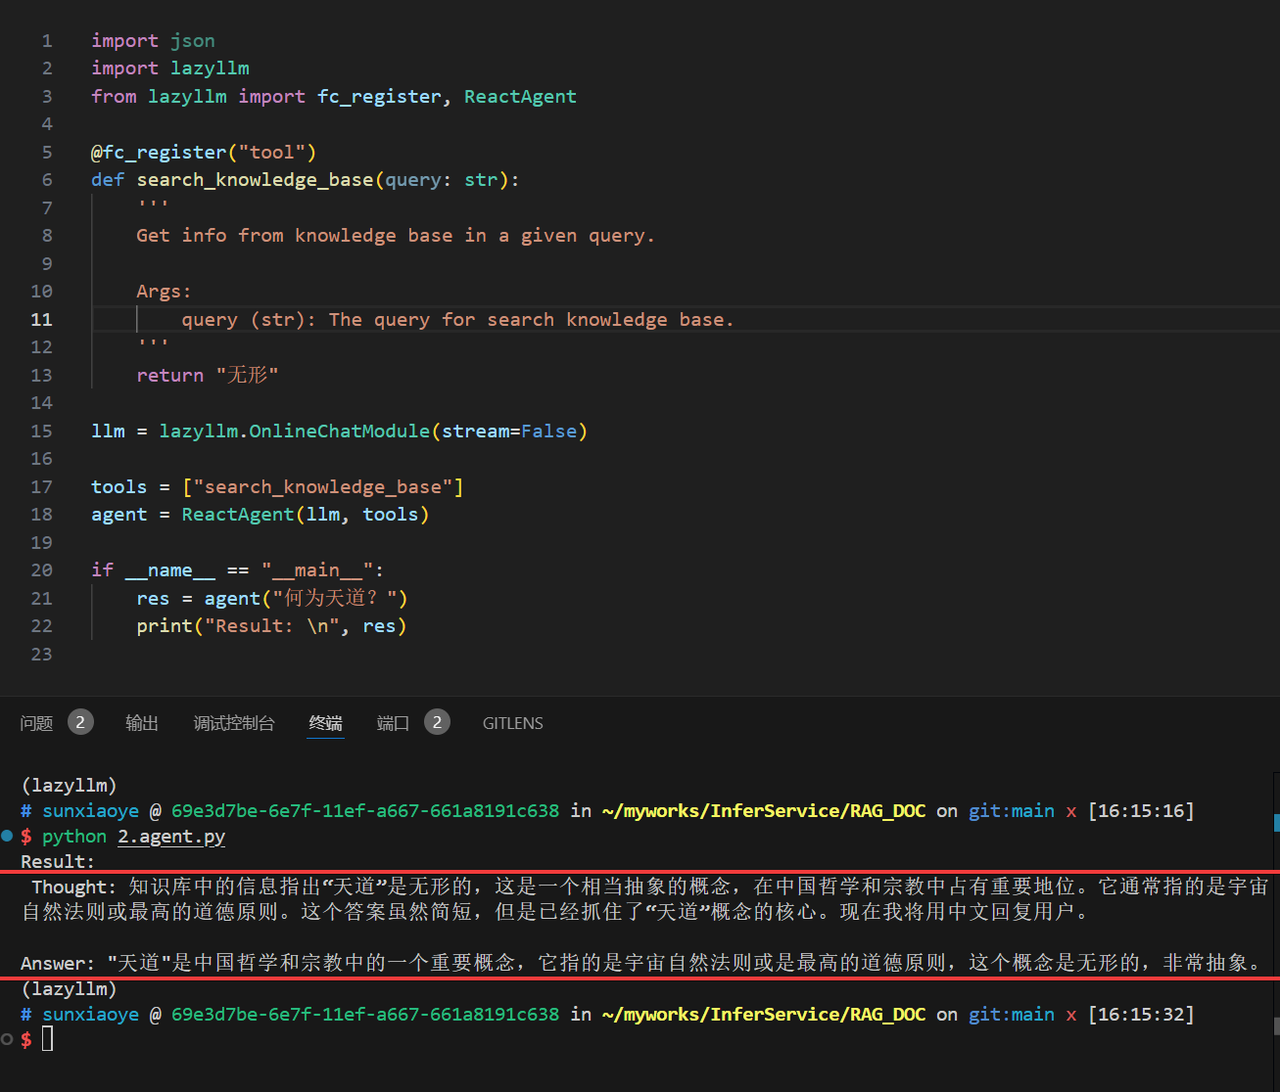

有了 React，我们就可以将它的工具替换为 RAG 中的 Retriever 和 Reranker 来作为一个真实的知识库。让它可以调用检索器：

In [ ]:
import lazyllm
from lazyllm import (pipeline, bind, OnlineEmbeddingModule, SentenceSplitter, Reranker,
                     Document, Retriever, fc_register, ReactAgent)

documents = Document(dataset_path="rag_master", embed=OnlineEmbeddingModule(), manager=False)
documents.create_node_group(name="sentences", transform=SentenceSplitter, chunk_size=1024, chunk_overlap=100)
with pipeline() as ppl_rag:
    ppl_rag.retriever = Retriever(documents, group_name="sentences", similarity="cosine", topk=3)
    ppl_rag.reranker = Reranker("ModuleReranker", model=OnlineEmbeddingModule(type="rerank"), topk=1, output_format='content', join=True) | bind(query=ppl_rag.input)

@fc_register("tool")
def search_knowledge_base(query: str):
    '''
    Get info from knowledge base in a given query.

    Args:
        query (str): The query for search knowledge base.
    '''
    return ppl_rag(query)

tools = ["search_knowledge_base"]
llm = lazyllm.OnlineChatModule(stream=False)

agent = ReactAgent(llm, tools)

if __name__ == "__main__":
    res = agent("何为天道？")
    print("Result: \n", res)

运行结果如下：

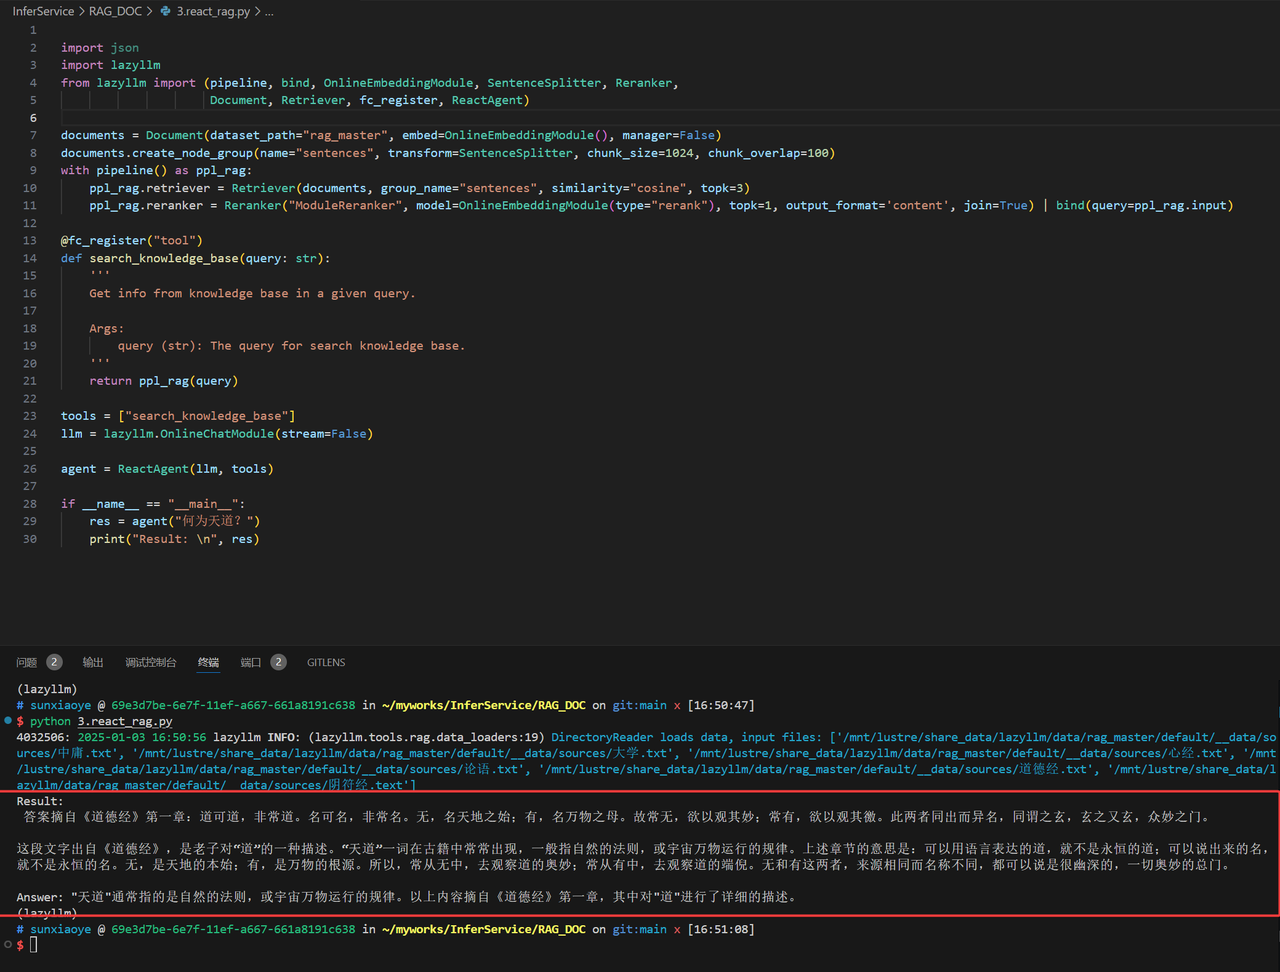

## 3. 实现 Agentic RAG

让我们将 RAG 的检索组件替换为带单个知识库的的 React，实现下面逻辑（这里简单起见，只用了一个知识库作为工具）

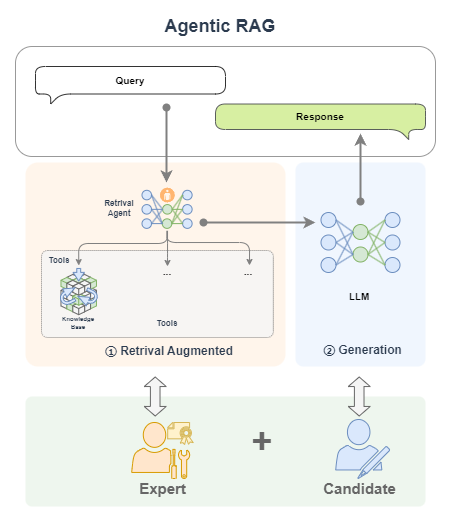

对应代码如下：

[代码GitHub链接](https://github.com/LazyAGI/Tutorial/blob/main/rag/codes/chapter18/rag_react.py)

In [ ]:
import lazyllm
from lazyllm import (pipeline, bind, OnlineEmbeddingModule, SentenceSplitter, Reranker,
                     Document, Retriever, fc_register, ReactAgent)

prompt = 'You will play the role of an AI Q&A assistant and complete a dialogue task. In this task, you need to provide your answer based on the given context and question.'

documents = Document(dataset_path="rag_master", embed=OnlineEmbeddingModule(), manager=False)
documents.create_node_group(name="sentences", transform=SentenceSplitter, chunk_size=1024, chunk_overlap=100)
with pipeline() as ppl_rag:
    ppl_rag.retriever = Retriever(documents, group_name="sentences", similarity="cosine", topk=3)
    ppl_rag.reranker = Reranker("ModuleReranker", model=OnlineEmbeddingModule(type="rerank"), topk=1, output_format='content', join=True) | bind(query=ppl_rag.input)

@fc_register("tool")
def search_knowledge_base(query: str):
    '''
    Get info from knowledge base in a given query.

    Args:
        query (str): The query for search knowledge base.
    '''
    return ppl_rag(query)

tools = ["search_knowledge_base"]

with pipeline() as ppl:
    ppl.retriever = ReactAgent(lazyllm.OnlineChatModule(stream=False), tools)
    ppl.formatter = (lambda nodes, query: dict(context_str=nodes, query=query)) | bind(query=ppl.input)
    ppl.llm = lazyllm.OnlineChatModule(stream=False).prompt(lazyllm.ChatPrompter(prompt, extro_keys=["context_str"]))

if __name__ == "__main__":
    lazyllm.WebModule(ppl, port=range(23467, 24000)).start().wait()

效果如下：

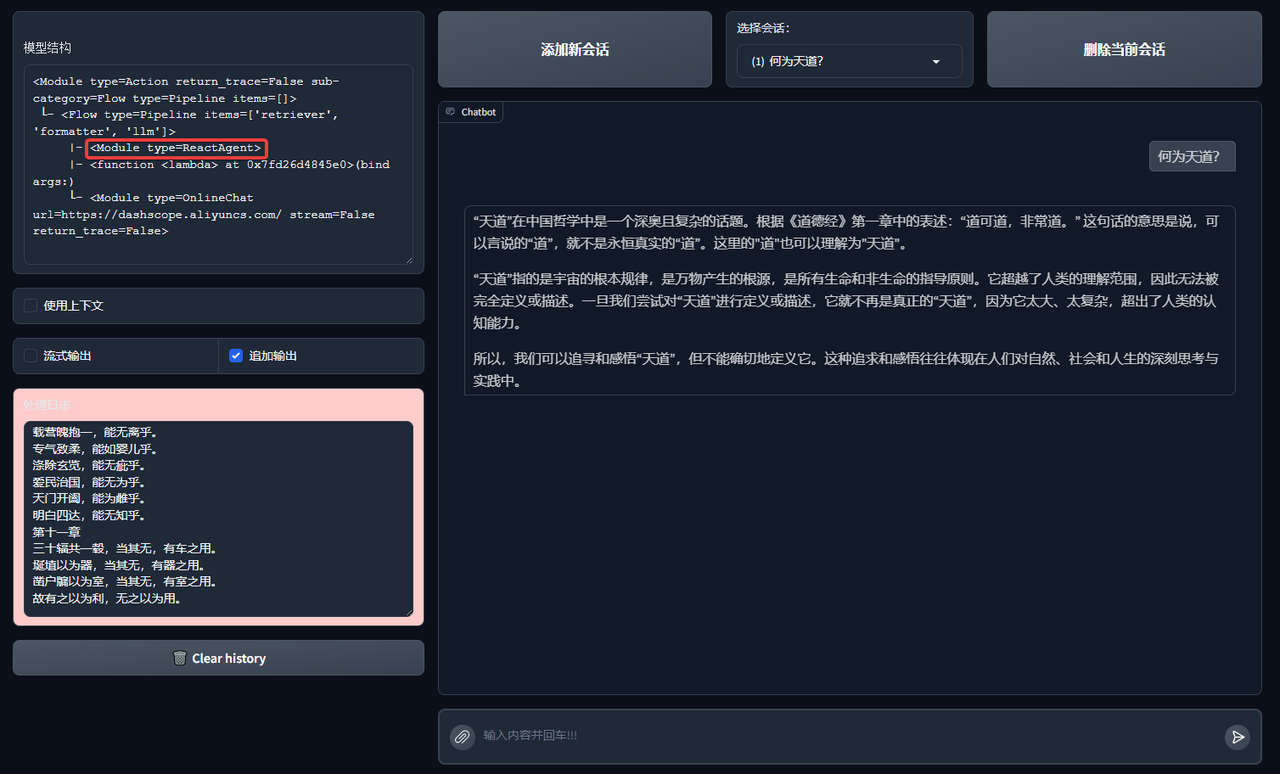

至此一个简单的 Agentic RAG 我们就实现了。

## 4. 更多的尝试

你可以尝试使用不同的 AI 智能体工作流来替换上面的 React：

[FunctionCallAgent代码GitHub链接](https://github.com/LazyAGI/Tutorial/blob/main/rag/codes/chapter18/rag_functioncall.py)

[PlanAndSolveAgent代码GitHub链接](https://github.com/LazyAGI/Tutorial/blob/main/rag/codes/chapter18/rag_planandsolve.py)

[ReWOOAgent代码GitHub链接](https://github.com/LazyAGI/Tutorial/blob/main/rag/codes/chapter18/rag_rewoo.py)

In [ ]:
from lazyllm import FunctionCallAgent, PlanAndSolveAgent, ReWOOAgent

# Use FunctionCallAgent:
ppl.retriever = FunctionCallAgent(lazyllm.OnlineChatModule(), tools)
# Use PlanAndSolveAgent:
ppl.retriever = PlanAndSolveAgent(lazyllm.OnlineChatModule(), tools)
# Use ReWOOAgent:
ppl.retriever = ReWOOAgent(lazyllm.OnlineChatModule(), tools)

这里我们尝试将ReactAgent 分别替换为FunctionCallAgent, PlanAndSolveAgent, ReWOOAgent来查看效果：

### FunctionCallAgent

FunctionCallAgent的效果：

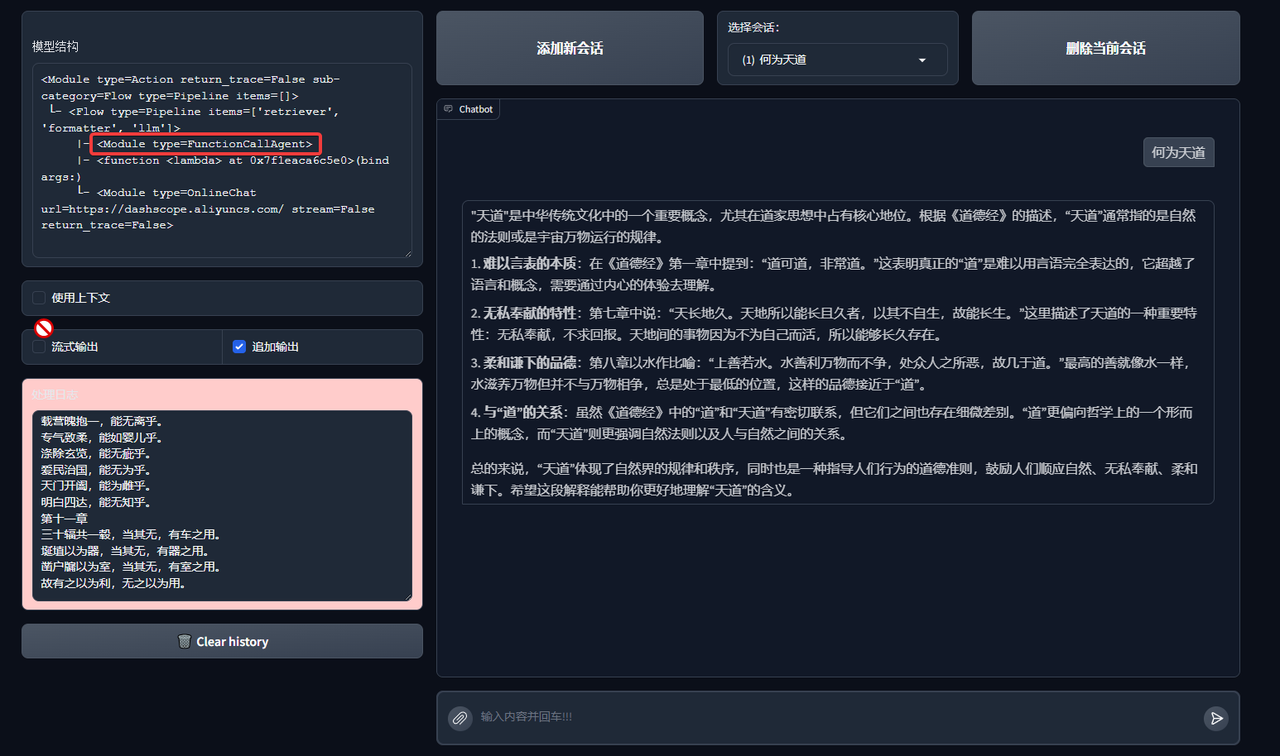

### PlanAndSolveAgent

PlanAndSolveAgent的效果：

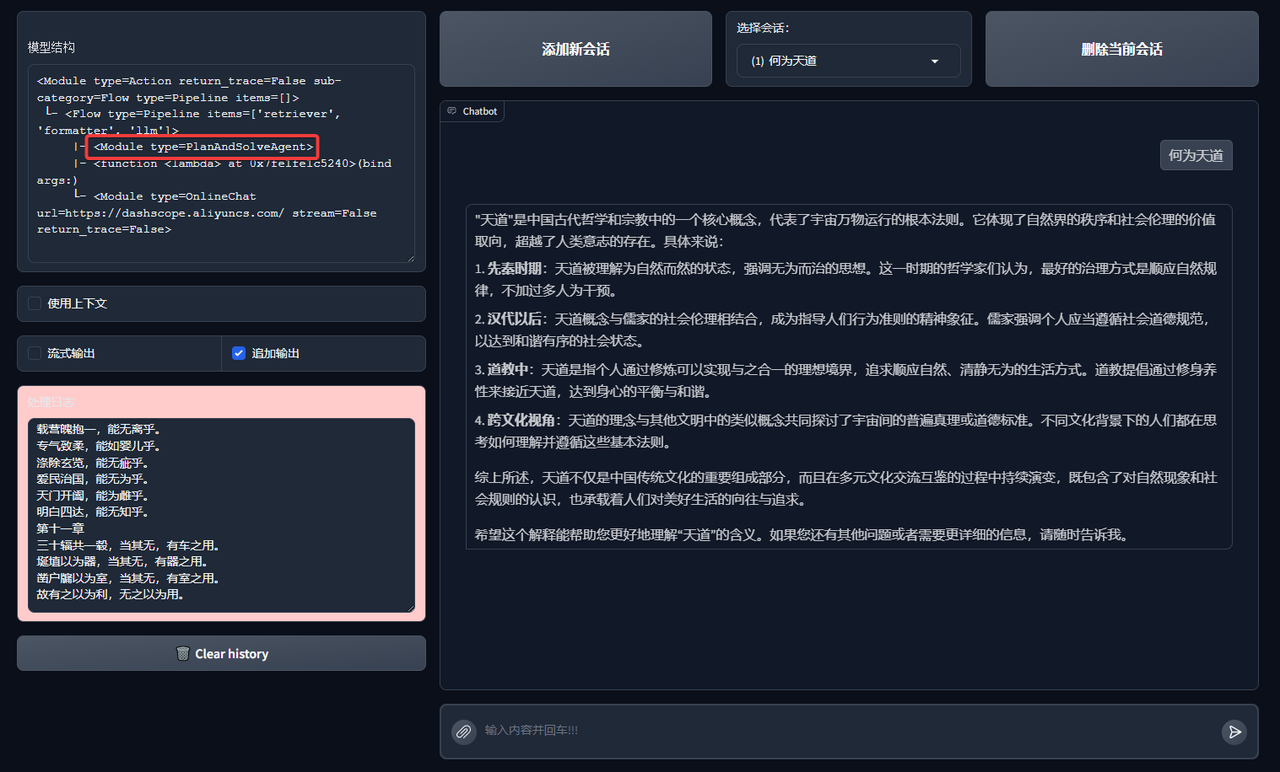

### ReWOOAgent

ReWOOAgent的效果：

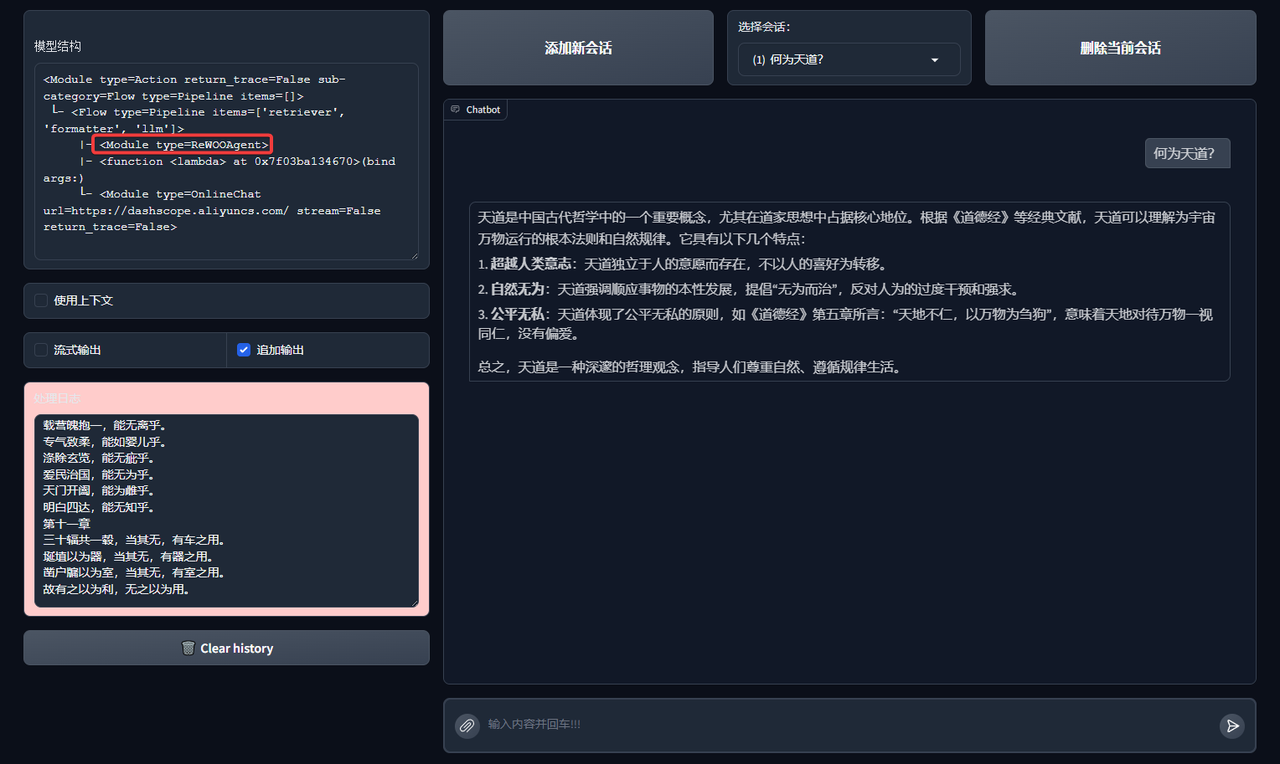

甚至你也可以引入多AI智能体，以及更多的RAG组件！快试试看吧。

# 扩展案例：多Agent RAG

为提升复杂问题的覆盖率与响应质量，还可以引入多Agent RAG的架构设计：

🔧 Agent 分工

检索Agent：根据查询内容确定检索工具（本地知识库/网络搜索）。

Agent A（知识库专家）：负责本地知识库的高效检索，优先处理结构化、稳定信息。

Agent B（网络搜索专家）：执行网页搜索、数据内容提取，并写入本地。

检索完成后，所有结果统一送入LLM生成响应，保证语言质量与上下文一致性

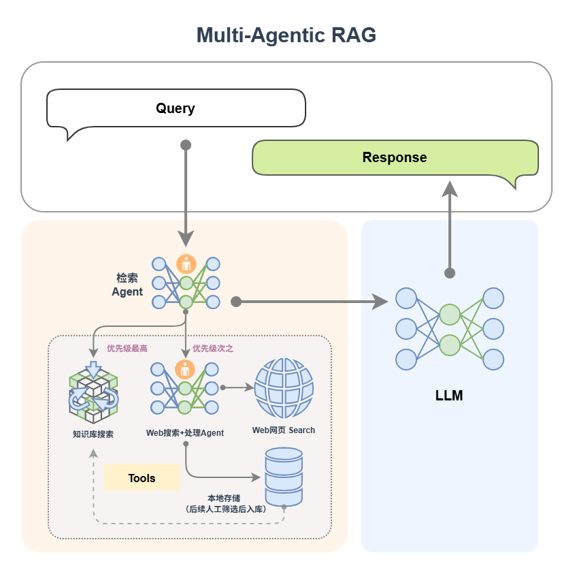

MCP网络搜索工具定义与注册

In [ ]:
# MCP-Search Web and Save Local
mcp_client1 = lazyllm.tools.MCPClient(command_or_url="python", args=["-m", "mcp_server_fetch"],)
search_agent = CustomReactAgent(llm=lazyllm.OnlineChatModule(source="sensenova", stream=False),
    stream=False, custom_prompt=search_prompt, tools=mcp_client1.get_tools())

@fc_register("tool")
def search_web(query: str):
    '''
    Perform targeted web content retrieval using a combination of search terms and URL.
    This tool processes both natural language requests and specific webpage addresses 
    to locate relevant online information.
    Args:
        query (str): Combined input containing search keywords and/or target URL 
                   (e.g., "AI news from https://example.com/tech-updates")
    '''
    query += search_prompt
    res = search_agent(query)
    return res

RAG工具定义与注册+应用编排

In [ ]:
# RAG-Retriever
documents = Document(dataset_path='path/to/kb', manager=False)
documents.add_reader('*.json', process_json)
with pipeline() as ppl_rag:
    ppl_rag.retriever = Retriever(documents, Document.CoarseChunk,
        similarity="bm25", topk=1, output_format='content', join='='*20)
@fc_register("tool")
def search_knowledge_base(query: str):
    '''
    Get info from knowledge base in a given query.
    Args:
        query (str): The query for search knowledge base.
    '''
    res = ppl_rag(query)
    return res

# Agentic-RAG:
tools = ['search_knowledge_base', 'search_web']
with pipeline() as ppl:
    ppl.retriever = CustomReactAgent(lazyllm.OnlineChatModule(stream=False), tools, agent_prompt, stream=False)
    ppl.formatter = (lambda nodes, query: dict(context_str=nodes, query=query)) | bind(query=ppl.input)
    ppl.llm = lazyllm.OnlineChatModule(stream=False).prompt(lazyllm.ChatPrompter(gen_prompt, extra_keys=["context_str"]))
# Launch: Web-UI
lazyllm.WebModule(ppl, port=range(23467, 24000), stream=True).start().wait()


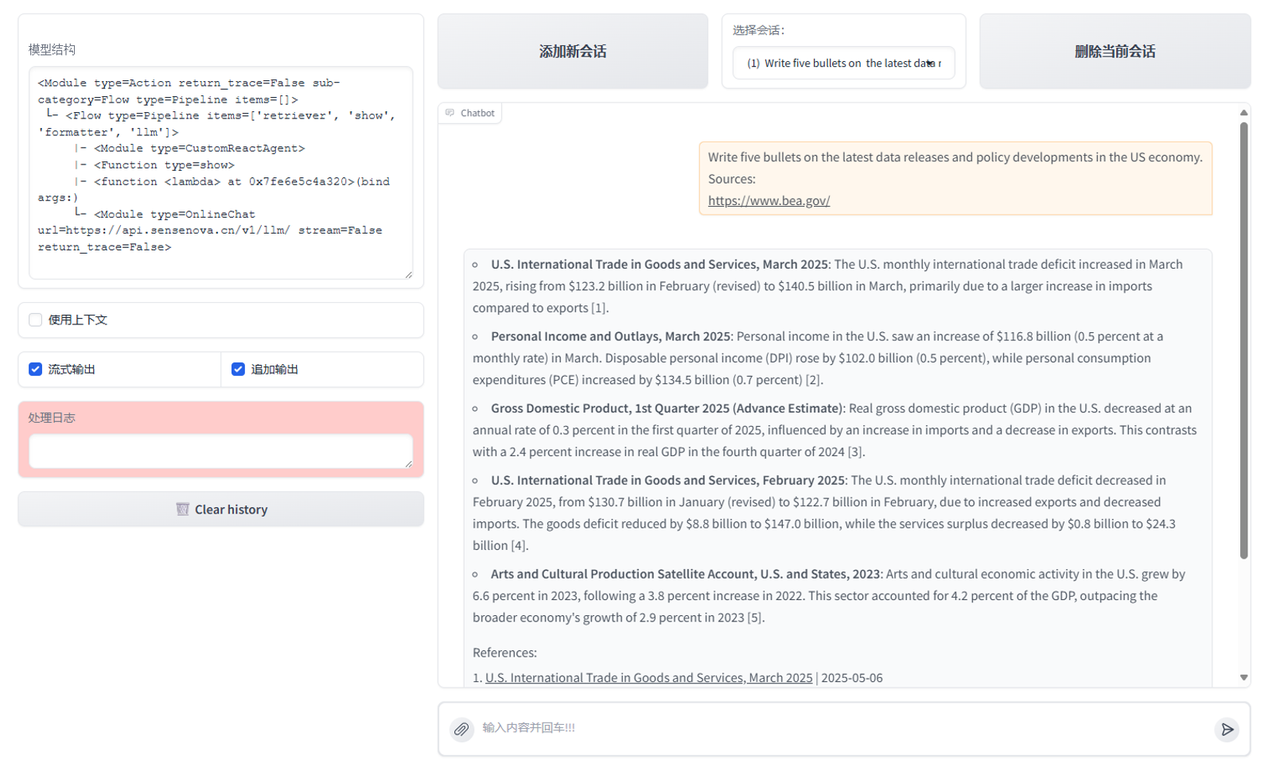

# 多模态Agentic RAG论文系统

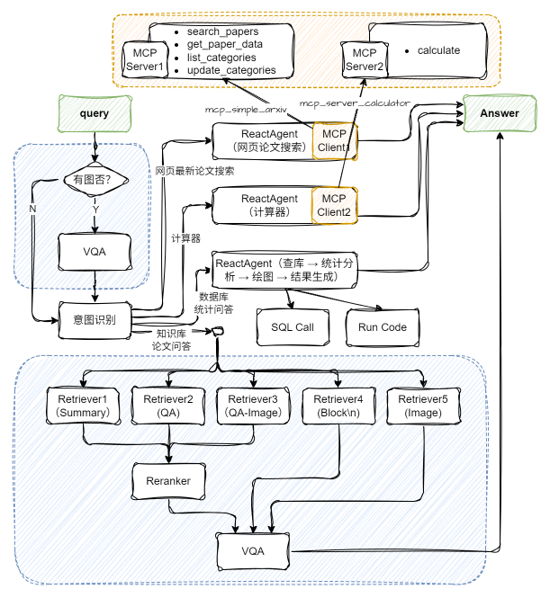

配置两个MCP工具及Agent

[代码GitHub链接](https://github.com/LazyAGI/Tutorial/blob/main/rag/courseware_codes/chapter18/mcp_agent.py)

In [ ]:
import json
import lazyllm
from lazyllm import ReactAgent
mcp_client1 = lazyllm.tools.MCPClient(
    command_or_url="python",
    args=["-m", "mcp_simple_arxiv"],
)
mcp_client2 = lazyllm.tools.MCPClient(
    command_or_url="python",
    args=["-m", "mcp_server_calculator"],
)
llm = lazyllm.OnlineChatModule(stream=False)
paper_agent = ReactAgent(llm, mcp_client1.get_tools(), return_trace=True)
calculator_agent = ReactAgent(llm, mcp_client2.get_tools(), return_trace=True)

环境中需提取安装好两个工具：

```bash
pip install mcp-simple-arxiv
pip install mcp-server-calculator
```

应用编排

[代码GitHub链接](https://github.com/LazyAGI/Tutorial/blob/7abc91dbb82a007a78731845dd8c360ac0cc1e75/rag/courseware_codes/chapter18/paper_assistant_multimodal.py#L25)

In [ ]:
# 构建 rag 工作流和统计分析工作流
rag_ppl = build_paper_rag()
sql_ppl = build_statistical_agent()
# 搭建具备知识问答和统计问答能力的主工作流
def build_paper_assistant():
    llm = OnlineChatModule(source='qwen', stream=False)
    vqa = lazyllm.OnlineChatModule(source="sensenova",\
        model="SenseNova-V6-Turbo").prompt(lazyllm.ChatPrompter(gen_prompt))
    with pipeline() as ppl:
        ppl.ifvqa = lazyllm.ifs(
            lambda x: x.startswith('<lazyllm-query>'),
            lambda x: vqa(x), lambda x:x)
        with IntentClassifier(llm) as ppl.ic:
            ppl.ic.case["论文问答", rag_ppl]
            ppl.ic.case["统计问答", sql_ppl]
            ppl.ic.case["计算器", calculator_agent]
            ppl.ic.case["网页最新论文搜索", paper_agent]
    return ppl
if __name__ == "__main__":
    main_ppl = build_paper_assistant()
    lazyllm.WebModule(main_ppl, port=23459, static_paths="./images", encode_files=True).start().wait()

[相关视频：video/多模态Agentic_RAG论文系统演示.mp4](video/多模态Agentic_RAG论文系统演示.mp4)